## 모델 학습을 위한 데이터 전처리

로컬 데이터 불러오는중...
학습 데이터 로딩 중...
검증 데이터 로딩 중...
증강 ALL 검증 데이터 로딩 중...
증강 rotate 검증 데이터 로딩 중...
증강 scale 검증 데이터 로딩 중...
증강 shear 검증 데이터 로딩 중...
증강 shift 검증 데이터 로딩 중...

원본 학습 데이터 Shape: (60000, 28, 28, 3)
색상 분류용 데이터 (Color): (60000, 2352)

배경 제거 중 (코너 기반 Rule-based)...
배경 제거 후 학습 데이터 Shape: (60000, 28, 28, 3)
배경 제거 후 검증 데이터 Shape: (10000, 28, 28, 3)


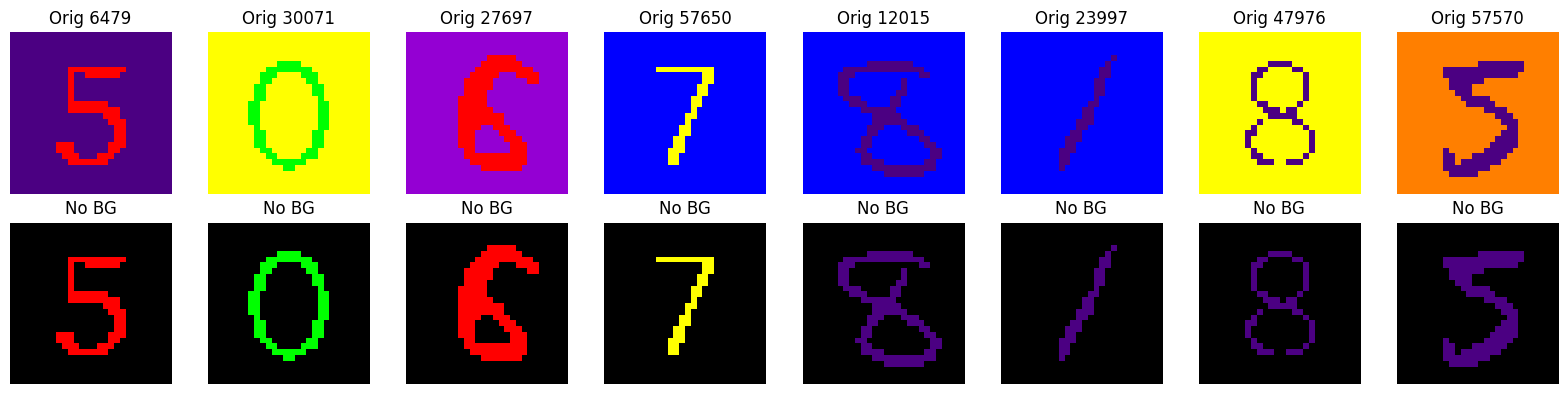


색상 분류용 데이터 (원본 Color): (60000, 2352)
색상 분류용 데이터 (배경제거 Color): (60000, 2352)


In [152]:
import numpy as np
import os
import time
import cupy as cp
#from google.colab import drive
from tqdm.notebook import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

# 3개의 핵심 모델 임포트
#from sklearn.ensemble import RandomForestClassifier
from cuml.ensemble import RandomForestClassifier as cuRF
import xgboost as xgb
import lightgbm as lgb

#from sklearn.metrics import classification_report, roc_auc_score
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.metrics import roc_auc_score as cuml_roc_auc_score
from sklearn.metrics import accuracy_score as sk_accuracy_score
from sklearn.metrics import roc_auc_score as sk_roc_auc_score
from sklearn.metrics import classification_report as sk_classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="Using CPU for workflow synchronization")

# --- 1. 설정 및 데이터 로딩 ---
print("로컬 데이터 불러오는중...")

BASE_DIR = 'Data'
SAVE_PATH_TRAIN = os.path.join(BASE_DIR, 'colored_mnist_train.npz')
SAVE_PATH_VAL = os.path.join(BASE_DIR, 'colored_mnist_val.npz')
SAVE_PATH_VAL_ALL = os.path.join(BASE_DIR, 'colored_mnist_valid_all.npz')
SAVE_PATH_VAL_ROTATE = os.path.join(BASE_DIR, 'colored_mnist_valid_rotate.npz')
SAVE_PATH_VAL_SCALE = os.path.join(BASE_DIR, 'colored_mnist_valid_scale.npz')
SAVE_PATH_VAL_SHEAR = os.path.join(BASE_DIR, 'colored_mnist_valid_shear.npz')
SAVE_PATH_VAL_SHIFT = os.path.join(BASE_DIR, 'colored_mnist_valid_shift.npz')

NUM_CLASSES_DIGIT = 10  # 숫자 (0~9)
NUM_CLASSES_COLOR = 7   # 색상 (무지개 7색)

# 학습 데이터 로드
print("학습 데이터 로딩 중...")
train_data = np.load(SAVE_PATH_TRAIN)
X_train_color = train_data['images'].astype(np.float32)
y_train_digit = train_data['labels_digit'].astype(np.float32)
y_train_fg = train_data['labels_fg'].astype(np.float32)
y_train_bg = train_data['labels_bg'].astype(np.float32)

# 테스트 데이터 로드
print("검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL)
X_val_color = val_data['images'].astype(np.float32)
y_val_digit = val_data['labels_digit'].astype(np.float32)
y_val_fg = val_data['labels_fg'].astype(np.float32)
y_val_bg = val_data['labels_bg'].astype(np.float32)

print("증강 ALL 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_ALL)
X_val_all_color = val_data['images'].astype(np.float32)
y_val_all_digit = val_data['labels_digit'].astype(np.float32)
y_val_all_fg = val_data['labels_fg'].astype(np.float32)
y_val_all_bg = val_data['labels_bg'].astype(np.float32)

print("증강 rotate 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_ROTATE)
X_val_rotate_color = val_data['images'].astype(np.float32)
y_val_rotate_digit = val_data['labels_digit'].astype(np.float32)
y_val_rotate_fg = val_data['labels_fg'].astype(np.float32)
y_val_rotate_bg = val_data['labels_bg'].astype(np.float32)

print("증강 scale 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SCALE)
X_val_scale_color = val_data['images'].astype(np.float32)
y_val_scale_digit = val_data['labels_digit'].astype(np.float32)
y_val_scale_fg = val_data['labels_fg'].astype(np.float32)
y_val_scale_bg = val_data['labels_bg'].astype(np.float32)

print("증강 shear 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SHEAR)
X_val_shear_color = val_data['images'].astype(np.float32)
y_val_shear_digit = val_data['labels_digit'].astype(np.float32)
y_val_shear_fg = val_data['labels_fg'].astype(np.float32)
y_val_shear_bg = val_data['labels_bg'].astype(np.float32)

print("증강 shift 검증 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL_SHIFT)
X_val_shift_color = val_data['images'].astype(np.float32)
y_val_shift_digit = val_data['labels_digit'].astype(np.float32)
y_val_shift_fg = val_data['labels_fg'].astype(np.float32)
y_val_shift_bg = val_data['labels_bg'].astype(np.float32)

print(f"\n원본 학습 데이터 Shape: {X_train_color.shape}")


# --- 2. 데이터 전처리 ---
# 2-1. 색상 분류용 (Color 3D -> 1D Flatten)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color = X_val_color.reshape(X_val_color.shape[0], -1)
X_val_all_flat_color = X_val_all_color.reshape(X_val_color.shape[0], -1)
X_val_rotate_flat_color = X_val_rotate_color.reshape(X_val_color.shape[0], -1)
X_val_scale_flat_color = X_val_scale_color.reshape(X_val_color.shape[0], -1)
X_val_shear_flat_color = X_val_shear_color.reshape(X_val_color.shape[0], -1)
X_val_shift_flat_color = X_val_shift_color.reshape(X_val_color.shape[0], -1)

print(f"색상 분류용 데이터 (Color): {X_train_flat_color.shape}")
def remove_background_corner_rule(images, patch_size=2, threshold=30, bg_value=0):
    """
    images: (N, H, W, 3)  - RGB 이미지 (0~1 또는 0~255)
    patch_size: 코너에서 가져올 패치 크기 (2면 2x2)
    threshold: 배경으로 볼 색 거리 허용치 (클수록 더 많이 배경으로 봄)
    bg_value: 배경으로 덮어쓸 값 (0이면 검정)
    """
    N, H, W, C = images.shape
    out = np.zeros_like(images)

    for i in range(N):
        img = images[i]

        # 원본이 0~1 float 형식일 수도 있고, 0~255일 수도 있으니 uint8 기준으로 처리
        if img.max() <= 1.0:
            img_uint = (img * 255).astype(np.uint8)
            is_float = True
        else:
            img_uint = img.astype(np.uint8)
            is_float = False

        # 코너 패치들 가져오기 (4개 코너)
        tl = img_uint[0:patch_size, 0:patch_size, :]          # top-left
        tr = img_uint[0:patch_size, W-patch_size:W, :]        # top-right
        bl = img_uint[H-patch_size:H, 0:patch_size, :]        # bottom-left
        br = img_uint[H-patch_size:H, W-patch_size:W, :]      # bottom-right

        corner_pixels = np.concatenate([
            tl.reshape(-1, 3),
            tr.reshape(-1, 3),
            bl.reshape(-1, 3),
            br.reshape(-1, 3)
        ], axis=0)

        # 코너 평균 색 = 배경색으로 가정
        bg_color = corner_pixels.mean(axis=0)  # (3,)

        # 각 픽셀과 배경색 거리 계산
        diff = np.linalg.norm(img_uint - bg_color, axis=2)  # (H, W)

        # threshold 이하인 픽셀은 배경으로 처리
        mask_bg = diff < threshold

        out_uint = img_uint.copy()
        out_uint[mask_bg] = bg_value  # 배경 제거(검정으로)

        # 다시 원래 스케일로 복원
        if is_float:
            out[i] = out_uint.astype(np.float32) / 255.0
        else:
            out[i] = out_uint

    return out


print("\n배경 제거 중 (코너 기반 Rule-based)...")
X_train_nobg = remove_background_corner_rule(X_train_color, patch_size=2, threshold=30, bg_value=0)
X_val_nobg   = remove_background_corner_rule(X_val_color,   patch_size=2, threshold=30, bg_value=0)
X_val_all_nobg   = remove_background_corner_rule(X_val_all_color,   patch_size=2, threshold=30, bg_value=0)
X_val_rotate_nobg   = remove_background_corner_rule(X_val_rotate_color,   patch_size=2, threshold=30, bg_value=0)
X_val_scale_nobg   = remove_background_corner_rule(X_val_scale_color,   patch_size=2, threshold=30, bg_value=0)
X_val_shear_nobg   = remove_background_corner_rule(X_val_shear_color,   patch_size=2, threshold=30, bg_value=0)
X_val_shift_nobg   = remove_background_corner_rule(X_val_shift_color,   patch_size=2, threshold=30, bg_value=0)
print("배경 제거 후 학습 데이터 Shape:", X_train_nobg.shape)
print("배경 제거 후 검증 데이터 Shape:", X_val_nobg.shape)


# ===============================
# 3. 배경제거 결과 시각화 (샘플 8개)
# ===============================
num_samples = 8
idx = np.random.choice(X_train_color.shape[0], num_samples, replace=False)

plt.figure(figsize=(16, 4))

# 1행: 원본 / 2행: 배경제거 결과
for col, i in enumerate(idx):
    # 원본
    ax1 = plt.subplot(2, num_samples, col + 1)
    ax1.imshow(X_train_color[i])
    ax1.axis('off')
    ax1.set_title(f"Orig {i}")

    # 배경제거
    ax2 = plt.subplot(2, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_nobg[i])
    ax2.axis('off')
    ax2.set_title("No BG")

plt.tight_layout()
plt.show()


# ===============================
# 4. 색상 분류용 Flatten (원본 / 배경제거 둘 다 만들어두기)
# ===============================

# (1) 원본 Color -> Flatten  (BG Color 등 원본이 필요한 경우)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color   = X_val_color.reshape(X_val_color.shape[0], -1)
print(f"\n색상 분류용 데이터 (원본 Color): {X_train_flat_color.shape}")

# (2) 배경 제거 버전 -> Flatten (Digit / FG Color 등에서 사용)
X_train_flat_nobg = X_train_nobg.reshape(X_train_nobg.shape[0], -1)
X_val_flat_nobg   = X_val_nobg.reshape(X_val_nobg.shape[0], -1)
X_val_all_flat_nobg = X_val_all_nobg.reshape(X_val_color.shape[0], -1)
X_val_rotate_flat_nobg = X_val_rotate_nobg.reshape(X_val_color.shape[0], -1)
X_val_scale_flat_nobg = X_val_scale_nobg.reshape(X_val_color.shape[0], -1)
X_val_shear_flat_nobg = X_val_shear_nobg.reshape(X_val_color.shape[0], -1)
X_val_shift_flat_nobg = X_val_shift_nobg.reshape(X_val_color.shape[0], -1)
print(f"색상 분류용 데이터 (배경제거 Color): {X_train_flat_nobg.shape}")

## 그레이 스케일 없이 모델 학습

In [95]:
print("\n--- 3종 모델 학습 시작 (총 9개) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # RandomForest
    ("cuRF - Digit", cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1), X_train_flat_color, y_train_digit),
    ("cuRF - FG Color", cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1), X_train_flat_color, y_train_fg),
    ("cuRF - BG Color", cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1), X_train_flat_color, y_train_bg),
    # XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT, tree_method='hist', device='cuda'), X_train_flat_color, y_train_digit),
    ("XGBoost - FG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR, tree_method='hist', device='cuda'), X_train_flat_color, y_train_fg),
    ("XGBoost - BG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR, tree_method='hist', device='cuda'), X_train_flat_color, y_train_bg),
    # LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT), X_train_flat_color, y_train_digit),
    ("LightGBM - FG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_fg),
    ("LightGBM - BG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_bg),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model

print("--- 모든 모델 학습 완료 ---")


--- 3종 모델 학습 시작 (총 9개) ---


Overall Training Progress:   0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8624
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 2352
[LightGBM] [Info] Start training from score -2.282456
[LightGBM] [Info] Start training from score -2.298095
[LightGBM] [Info] Start training from score -2.320410
[LightGBM] [Info] Start training from score -2.316515
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.295609
[LightGBM] [Info] Start training from score -2.296934
[LightGBM] [Info] Start training from score -2.317022
[LightGBM] [Info] Start training from score -2.307095
[LightGBM] [Info] Start training from score -2.309778
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020142 seconds.
Y

## 그레이스케일 미적용 모델 성능 평가

In [96]:
def evaluate_model_org(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_color, y_val_digit
    elif "FG Color" in model_name:
        X_val, y_val = X_val_flat_color, y_val_fg
    else: # BG Color
        X_val, y_val = X_val_flat_color, y_val_bg

    # 2. 예측 (cuRF만 GPU->CPU 변환 처리)
    if "cuRF" in model_name:
        import cupy as cp
        # cuRF는 GPU 배열 입력 권장
        X_val_gpu = cp.asarray(X_val)
        # 결과가 GPU 배열이므로 .get()으로 CPU로 가져옵니다
        y_pred = model_obj.predict(X_val_gpu).get()
        y_proba = model_obj.predict_proba(X_val_gpu).get()
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)

    # 3. 결과 출력 (님이 원하신 sklearn 함수 사용)
    print(sk_classification_report(y_val, y_pred, digits=4))
    
    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model_org(name, model)


--- 최종 성능 평가 (Validation Set) ---

===== cuRF - Digit =====
              precision    recall  f1-score   support

         0.0     0.9628    0.9856    0.9741       972
         1.0     0.9539    0.9922    0.9726      1021
         2.0     0.9556    0.9159    0.9353       939
         3.0     0.9389    0.9138    0.9262       975
         4.0     0.9302    0.9448    0.9374      1015
         5.0     0.9456    0.9291    0.9373      1029
         6.0     0.9616    0.9700    0.9658      1032
         7.0     0.9424    0.9510    0.9467       980
         8.0     0.9475    0.9188    0.9329      1022
         9.0     0.9098    0.9241    0.9169      1015

    accuracy                         0.9447     10000
   macro avg     0.9448    0.9445    0.9445     10000
weighted avg     0.9447    0.9447    0.9446     10000

** Weighted-Average AUC: 0.9957 **

===== cuRF - FG Color =====
              precision    recall  f1-score   support

         0.0     1.0000    0.9993    0.9996      1398
       

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_color
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat_color
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat_color
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from cuml.manifold import UMAP, TSNE

# --- 1. 공통 임베딩 생성 (이전과 동일, 이미 계산했다면 생략 가능) ---
# (만약 위에서 이미 X_tsne, X_umap을 계산했다면 이 부분은 주석 처리하세요)
if 'X_tsne' not in locals():
    print(">>> 차원 축소 좌표 계산 중 (Validation Set)...")
    X_val_gpu = cp.asarray(X_val_flat_color)
    umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = umap_model.fit_transform(X_val_gpu).get()
    tsne_model = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne_model.fit_transform(X_val_gpu).get()
    print(">>> 좌표 계산 완료\n")

# --- 2. 태스크별 시각화 함수 (정답 제거 버전) ---
def plot_model_predictions_only(task_name):
    print(f"--- Viz: {task_name} (Models Only) ---")
    
    # 해당 태스크의 모델들 찾기
    models_for_task = {k: v for k, v in trained_models.items() if task_name in k}
    
    # 제목과 예측값 수집
    titles = list(models_for_task.keys())
    predictions = []
    
    for name, model in models_for_task.items():
        # 모델별 예측 (데이터 타입 주의)
        if "cuRF" in name:
            pred = model.predict(X_val_gpu).get()
        else:
            pred = model.predict(X_val_flat_color)
        predictions.append(pred)
        
    # 그래프 그리기 (2행 3열: 정답 제외)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)
    
    # (Row 1) t-SNE
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[0, i].set_title(f"t-SNE: {title}", fontsize=14, fontweight='bold')
        axes[0, i].axis('off')
        
    # (Row 2) UMAP
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[1, i].set_title(f"UMAP: {title}", fontsize=14, fontweight='bold')
        axes[1, i].axis('off')

    # 공통 컬러바
    cbar = fig.colorbar(scatter, ax=axes[:, :], location='right', shrink=0.6)
    cbar.set_label(f'{task_name} Predicted Class', fontsize=14)
    
    plt.suptitle(f"Model Predictions Comparison: {task_name}", fontsize=22)
    plt.show()

# --- 3. 전체 실행 ---

# (1) 숫자 분류 (Digit)
plot_model_predictions_only("Digit")

# (2) 전경색 분류 (FG Color)
plot_model_predictions_only("FG Color")

# (3) 배경색 분류 (BG Color)
plot_model_predictions_only("BG Color")

## 그레이 스케일 적용 모델 학습

In [97]:
# 2-2. 숫자 분류용 (Color 3D -> Grayscale 2D -> 1D Flatten)
X_train_gray = np.dot(X_train_color[...,:3], [0.299, 0.587, 0.114])
X_val_gray = np.dot(X_val_color[...,:3], [0.299, 0.587, 0.114])
X_train_flat_gray = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_val_flat_gray = X_val_gray.reshape(X_val_gray.shape[0], -1)

print(f"숫자 분류용 데이터 (Gray): {X_train_flat_gray.shape}")

print("\n--- 3종 모델 학습 시작 (총 3개) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # RandomForest
    ("cuRF - Digit", cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1), X_train_flat_gray, y_train_digit),
    # XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT, tree_method='hist', device='cuda'), X_train_flat_gray, y_train_digit),
    # LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT), X_train_flat_gray, y_train_digit)
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall GPU Training Progress"):
    start_time = time.time()
    print(f"\n[훈련 중] {name}...")
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model # 학습 완료된 모델을 이름과 함께 저장
    print(f" -> {name} 훈련 완료 (소요 시간: {time.time() - start_time:.2f}초)")

print("--- 모든 모델 학습 완료 ---")

숫자 분류용 데이터 (Gray): (60000, 784)

--- 3종 모델 학습 시작 (총 3개) ---


Overall GPU Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


[훈련 중] cuRF - Digit...
 -> cuRF - Digit 훈련 완료 (소요 시간: 3.26초)

[훈련 중] XGBoost - Digit...
 -> XGBoost - Digit 훈련 완료 (소요 시간: 7.72초)

[훈련 중] LightGBM - Digit...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6272
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 784
[LightGBM] [Info] Start training from score -2.282456
[LightGBM] [Info] Start training from score -2.298095
[LightGBM] [Info] Start training from score -2.320410
[LightGBM] [Info] Start training from score -2.316515
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.295609
[LightGBM] [Info] Start training from score -2.296934
[LightGBM] [Info] Start training from score -2.317022
[LightGBM] [Info] Start training from score -2.307095
[L

## 그레이스케일 적용 모델 성능 평가

In [98]:
def evaluate_model_gray(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit

    # 2. 예측 (cuRF만 GPU->CPU 변환 처리)
    if "cuRF" in model_name:
        import cupy as cp
        # cuRF는 GPU 배열 입력 권장
        X_val_gpu = cp.asarray(X_val)
        # 결과가 GPU 배열이므로 .get()으로 CPU로 가져옵니다
        y_pred = model_obj.predict(X_val_gpu).get()
        y_proba = model_obj.predict_proba(X_val_gpu).get()
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)

    # 3. 결과 출력 (님이 원하신 sklearn 함수 사용)
    print(sk_classification_report(y_val, y_pred, digits=4))
    
    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model_gray(name, model)


--- 최종 성능 평가 (Validation Set) ---

===== cuRF - Digit =====
              precision    recall  f1-score   support

         0.0     0.9605    0.9763    0.9684       972
         1.0     0.9503    0.9922    0.9708      1021
         2.0     0.9410    0.9180    0.9294       939
         3.0     0.9363    0.9190    0.9275       975
         4.0     0.9382    0.9576    0.9478      1015
         5.0     0.9369    0.9242    0.9305      1029
         6.0     0.9579    0.9709    0.9644      1032
         7.0     0.9549    0.9510    0.9530       980
         8.0     0.9532    0.9159    0.9341      1022
         9.0     0.9342    0.9369    0.9356      1015

    accuracy                         0.9464     10000
   macro avg     0.9463    0.9462    0.9461     10000
weighted avg     0.9464    0.9464    0.9462     10000

** Weighted-Average AUC: 0.9948 **

===== XGBoost - Digit =====
              precision    recall  f1-score   support

         0.0     0.9673    0.9743    0.9708       972
       

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## HOG Feature 추가 모델 학습

In [99]:

# HOG 파라미터 (이 기본값이 MNIST에 최적화되어 있어)
ppc = 8
cpb = 2

# 학습 데이터에서 HOG 피처 추출
X_train_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_train_gray, desc="학습 데이터 HOG 변환")])

# 테스트 데이터에서 HOG 피처 추출
X_val_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_val_gray, desc="테스트 데이터 HOG 변환")])

print(f"HOG 피처 Shape: {X_train_hog.shape}")
# --- 4. HOG 피처로 모델 학습 및 비교 ---
print("\n--- HOG 피처로 최종 모델 학습 시작 ---")

# --- 4-1. cuML RandomForest with HOG ---
print("[1/3] cuML RandomForest 모델 학습 중 (HOG)...")
start_time = time.time()
# [수정] n_jobs=-1 제거, max_depth=16 권장
digit_model_rf_hog = cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1)
digit_model_rf_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-2. XGBoost with HOG ---
print("[2/3] XGBoost 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_xgb_hog = xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT, tree_method='hist', device='cuda')
digit_model_xgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-3. LightGBM with HOG ---
print("[3/3] LightGBM 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_lgb_hog = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT)
digit_model_lgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")




학습 데이터 HOG 변환:   0%|          | 0/60000 [00:00<?, ?it/s]

테스트 데이터 HOG 변환:   0%|          | 0/10000 [00:00<?, ?it/s]

HOG 피처 Shape: (60000, 144)

--- HOG 피처로 최종 모델 학습 시작 ---
[1/3] cuML RandomForest 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 2.34초)
[2/3] XGBoost 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 4.87초)
[3/3] LightGBM 모델 학습 중 (HOG)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 64
[LightGBM] [Info] Start training from score -2.282456
[LightGBM] [Info] Start training from score -2.298095
[LightGBM] [Info] Start training from score -2.320410
[LightGBM] [Info] Start training from score -2.316515
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.295609
[LightGBM] [Info] Start training from score -2.296934
[LightGBM] [Info] Start training from score -2.317022
[Lig

## HOG Feature 추가 모델 성능

In [100]:
def evaluate_model_hog(model, model_name, X_val_hog_data, y_val_digit_data):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit

    # 2. 예측 (cuRF만 GPU->CPU 변환 처리)
    if "cuRF" in model_name:
        import cupy as cp
        # cuRF는 GPU 배열 입력 권장
        X_val_gpu = cp.asarray(X_val)
        # 결과가 GPU 배열이므로 .get()으로 CPU로 가져옵니다
        y_pred = model.predict(X_val_hog_data).get()
        y_proba = model.predict_proba(X_val_hog_data).get()
    else:
        # XGBoost, LightGBM
        y_pred = model.predict(X_val_hog_data)
        y_proba = model.predict_proba(X_val_hog_data)

    # 3. 결과 출력 (님이 원하신 sklearn 함수 사용)
    print(sk_classification_report(y_val, y_pred, digits=4))
    
    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set with hog) ---")

# 학습된 모델들을 순회하며 평가
evaluate_model_hog(digit_model_rf_hog, "RandomForest - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_xgb_hog, "XGBoost - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_lgb_hog, "LightGBM - Digit (HOG)", X_val_hog, y_val_digit)


--- 최종 성능 평가 (Validation Set with hog) ---

===== RandomForest - Digit (HOG) =====
              precision    recall  f1-score   support

         0.0     0.9807    0.9938    0.9872       972
         1.0     0.9931    0.9882    0.9907      1021
         2.0     0.9722    0.9670    0.9696       939
         3.0     0.9708    0.9559    0.9633       975
         4.0     0.9754    0.9783    0.9769      1015
         5.0     0.9635    0.9757    0.9696      1029
         6.0     0.9816    0.9806    0.9811      1032
         7.0     0.9761    0.9582    0.9670       980
         8.0     0.9507    0.9618    0.9562      1022
         9.0     0.9558    0.9586    0.9572      1015

    accuracy                         0.9719     10000
   macro avg     0.9720    0.9718    0.9719     10000
weighted avg     0.9719    0.9719    0.9719     10000

** Weighted-Average AUC: 0.9994 **

===== XGBoost - Digit (HOG) =====
              precision    recall  f1-score   support

         0.0     0.9888    0.995

--- Confusion Matrix 생성 중 ---


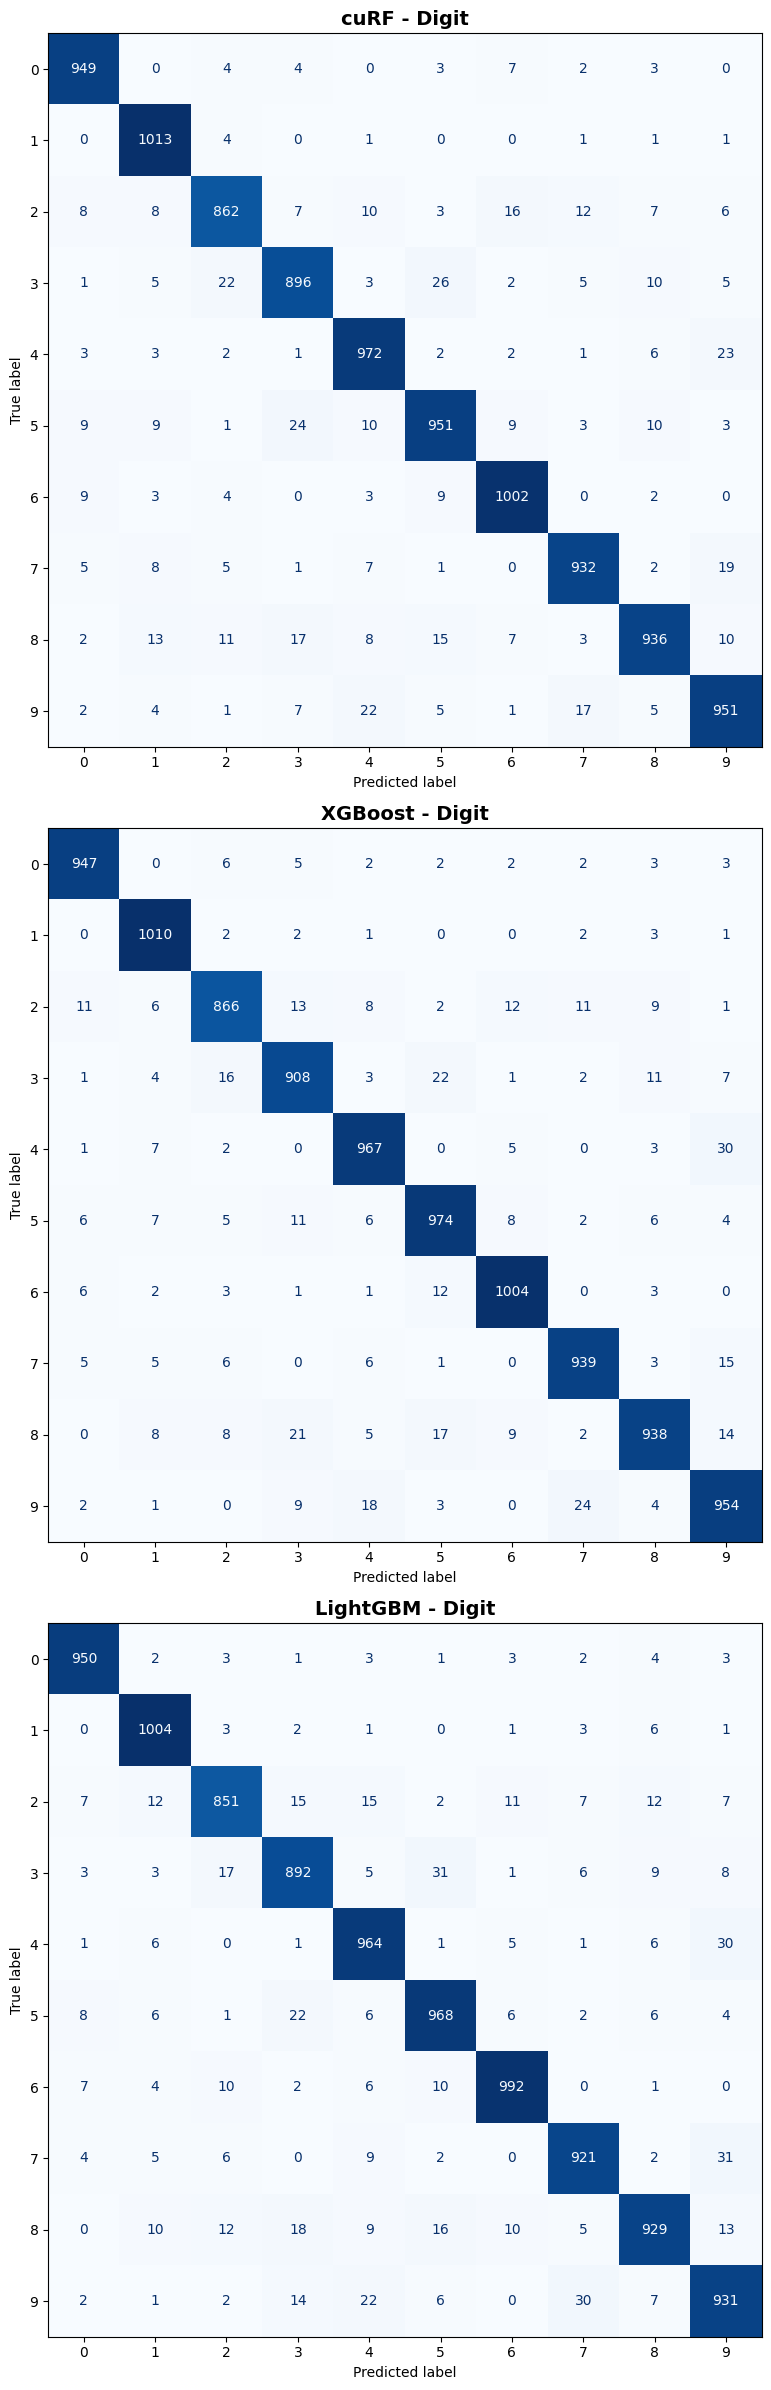

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 1, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## Hu moments 추가

In [93]:
from skimage.feature import hog
from skimage.measure import moments, moments_central, moments_normalized, moments_hu
import math

# --- 3. [추가] 고급 피처 추출 (HOG + Hu Moments) ---
print("\n--- 고급 피처 추출 시작 (HOG + Hu Moments) ---")

def get_hu_moments(img):
    """이미지에서 7개의 Hu Moments 불변량 추출 (로그 변환 적용)"""
    # 1. 일반 모멘트 계산
    m = moments(img)
    
    # 2. 무게 중심 계산 (이미지가 0인 경우 예외 처리)
    if m[0, 0] == 0:
        return np.zeros(7)
    cy = m[1, 0] / m[0, 0]
    cx = m[0, 1] / m[0, 0]
    
    # 3. 중심 모멘트 (이동 불변성)
    mu = moments_central(img, center=(cy, cx))
    
    # 4. 정규화된 중심 모멘트 (크기 불변성)
    nu = moments_normalized(mu)
    
    # 5. Hu Moments (회전 불변성)
    hu = moments_hu(nu)
    
    # 6. 스케일 조정을 위한 로그 변환 (부호 유지)
    # Hu 모멘트는 값이 매우 작으므로 로그를 취해 모델이 학습하기 좋게 만듭니다.
    for i in range(7):
        if hu[i] != 0:
            hu[i] = -1 * math.copysign(1.0, hu[i]) * math.log10(abs(hu[i]))
            
    return hu

def extract_advanced_features(images):
    feature_list = []
    # HOG 파라미터 설정 (28x28 이미지에 적합하게 조정)
    ppc = 8 # pixels_per_cell (4, 7, 14 등 약수 사용 권장)
    cpb = 2 # cells_per_block
    
    print(f"피처 추출 중... (총 {len(images)}개)")
    for img in tqdm(images):
        # A. HOG 피처 추출
        hog_feat = hog(img, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False)
        
        # B. Hu Moments 추출
        hu_feat = get_hu_moments(img)
        
        # C. 두 피처 결합 (Concatenate)
        combined = np.hstack([hog_feat, hu_feat])
        feature_list.append(combined)
        
    return np.array(feature_list, dtype=np.float32)

# 학습 및 검증 데이터에 적용
# (그레이스케일 이미지를 입력으로 사용합니다)
X_train_features = extract_advanced_features(X_train_gray)
X_val_features = extract_advanced_features(X_val_gray)

print(f"고급 피처 데이터 Shape: {X_train_features.shape}")
# 예: HOG(324개) + Hu(7개) = 331개 features

# --- 4. 고급 피처로 모델 학습 ---
print("\n--- 고급 피처(HOG+Hu) 모델 학습 시작 ---")

# 학습할 모델 목록 정의 (입력 데이터가 X_train_features로 변경됨)
training_jobs_advanced = [
    # RandomForest
    ("cuRF - Advanced", cuRF(n_estimators=100, random_state=42, max_depth=16, n_streams=1), X_train_features, y_train_digit),
    
    # XGBoost
    ("XGBoost - Advanced", xgb.XGBClassifier(n_estimators=100, random_state=42, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT, tree_method='hist', device='cuda'), X_train_features, y_train_digit),
    
    # LightGBM
    # (HOG/Hu 피처는 0이 아닌 값이 많으므로(Dense), LightGBM GPU 모드를 사용해도 안전합니다)
    ("LightGBM - Advanced", lgb.LGBMClassifier(n_estimators=100, random_state=42, objective='multiclass', num_class=NUM_CLASSES_DIGIT, device='cuda'), X_train_features, y_train_digit)
]

# 학습 실행
for name, model, X_tr, y_tr in tqdm(training_jobs_advanced, desc="Advanced Features Training"):
    start_time = time.time()
    print(f"\n[훈련 중] {name}...")
    
    model.fit(X_tr, y_tr)
    
    # 학습된 모델 저장 (기존 딕셔너리에 추가)
    trained_models[name] = model
    
    print(f" -> {name} 훈련 완료 (소요 시간: {time.time() - start_time:.2f}초)")

print("--- 고급 피처 모델 학습 완료 ---")


--- 고급 피처 추출 시작 (HOG + Hu Moments) ---
피처 추출 중... (총 60000개)


  0%|          | 0/60000 [00:00<?, ?it/s]

피처 추출 중... (총 10000개)


  0%|          | 0/10000 [00:00<?, ?it/s]

고급 피처 데이터 Shape: (60000, 151)

--- 고급 피처(HOG+Hu) 모델 학습 시작 ---


Advanced Features Training:   0%|          | 0/3 [00:00<?, ?it/s]


[훈련 중] cuRF - Advanced...
 -> cuRF - Advanced 훈련 완료 (소요 시간: 2.24초)

[훈련 중] XGBoost - Advanced...
 -> XGBoost - Advanced 훈련 완료 (소요 시간: 5.48초)

[훈련 중] LightGBM - Advanced...
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] Metric multi_logloss is not implemented in cuda version. Fall back to evaluation on CPU.
[LightGBM] [Info] Total Bins 18105
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 71
[LightGBM] [Info] Start training from score -2.282456
[LightGBM] [Info] Start training from score -2.298095
[LightGBM] [Info] Start training from score -2.320410
[LightGBM] [Info] Start training from score -2.316515
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.295609
[LightGBM] [Info] Start training from score -2.296934
[LightGBM] [Info] Start training from score -2.317022
[LightGBM] [Info] Start training from score -2.307095
[LightGBM] [Info] Star

## HOG + Humoments 성능 평가

In [ ]:
def evaluate_model_hoghu(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택 (Digit 전용)
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit
    else:
        print(f"Skipping {model_name} (Not a Digit model)")
        return

    # 2. 예측 (cuRF는 GPU 사용)
    if "cuRF" in model_name:
        import cupy as cp
        # 입력 데이터를 GPU로 이동
        X_val_gpu = cp.asarray(X_val)
        # 예측 및 확률 계산 후 CPU로 복귀 (.get())
        y_pred = model_obj.predict(X_val_gpu).get()
        y_proba = model_obj.predict_proba(X_val_gpu).get()
    else:
        # XGBoost, LightGBM은 CPU(Numpy) 데이터 바로 사용 가능
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)

    # 3. 결과 출력
    print(sk_classification_report(y_val, y_pred, digits=4))
    
    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set) ---")
for name, model in trained_models.items():
    evaluate_model_hoghu(name, model)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cupy as cp
import numpy as np

# 모델 개수에 맞춰 그래프 틀 잡기 (3개 모델)
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 가로로 배치
if len(trained_models) == 1: axes = [axes]
axes = axes.flatten()

print("--- Confusion Matrix 생성 중 ---")

for i, (name, model) in enumerate(trained_models.items()):
    
    # 1. 데이터 선택 (Grayscale 사용)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        continue # Digit 모델이 아니면 건너뜀

    # 2. 예측 수행 (cuRF 처리 추가)
    if "cuRF" in name:
        # GPU로 입력 -> 예측 -> CPU로 결과 가져오기
        y_pred = model.predict(cp.asarray(X_val)).get()
    else:
        # XGB/LGBM
        y_pred = model.predict(X_val)

    # 3. 행렬 계산 및 시각화
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
from cuml.manifold import UMAP, TSNE

# --- 1. 공통 임베딩 생성 (Grayscale 데이터 사용!) ---
# [!] 중요: 모델이 Grayscale로 학습했으므로, 시각화도 Grayscale 데이터로 해야 합니다.
print(">>> 차원 축소 좌표 계산 중 (Validation Set - Grayscale)...")

# 데이터를 GPU로 복사 (Grayscale 데이터 사용)
X_val_gpu = cp.asarray(X_val_flat_gray) 

# UMAP
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_val_gpu).get()

# t-SNE
tsne_model = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne_model.fit_transform(X_val_gpu).get()

print(">>> 좌표 계산 완료\n")


# --- 2. 태스크별 시각화 함수 ---
def plot_model_predictions_only(task_name):
    print(f"--- Viz: {task_name} (Models Only) ---")
    
    # 해당 태스크(Digit) 모델들 찾기
    models_for_task = {k: v for k, v in trained_models.items() if task_name in k}
    titles = list(models_for_task.keys())
    predictions = []
    
    for name, model in models_for_task.items():
        # 예측 수행 (cuRF 처리 포함)
        if "cuRF" in name:
            # 위에서 만든 X_val_gpu (Grayscale)를 그대로 사용
            pred = model.predict(X_val_gpu).get()
        else:
            # CPU 모델은 Numpy 데이터 사용
            pred = model.predict(X_val_flat_gray)
        predictions.append(pred)
        
    # 그래프 그리기 (2행 3열)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)
    
    # (Row 1) t-SNE
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[0, i].set_title(f"t-SNE: {title}", fontsize=14, fontweight='bold')
        axes[0, i].axis('off')
        
    # (Row 2) UMAP
    for i, (title, y_data) in enumerate(zip(titles, predictions)):
        scatter = axes[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y_data, cmap='tab10', s=1, alpha=0.7)
        axes[1, i].set_title(f"UMAP: {title}", fontsize=14, fontweight='bold')
        axes[1, i].axis('off')

    # 공통 컬러바
    cbar = fig.colorbar(scatter, ax=axes[:, :], location='right', shrink=0.6)
    cbar.set_label(f'{task_name} Predicted Class', fontsize=14)
    
    plt.suptitle(f"Model Predictions Comparison: {task_name} (Grayscale)", fontsize=22)
    plt.show()

# --- 3. 전체 실행 ---
# 숫자 분류 (Digit) 시각화
plot_model_predictions_only("Digit")

## 그레이스케일 파라미터 조정

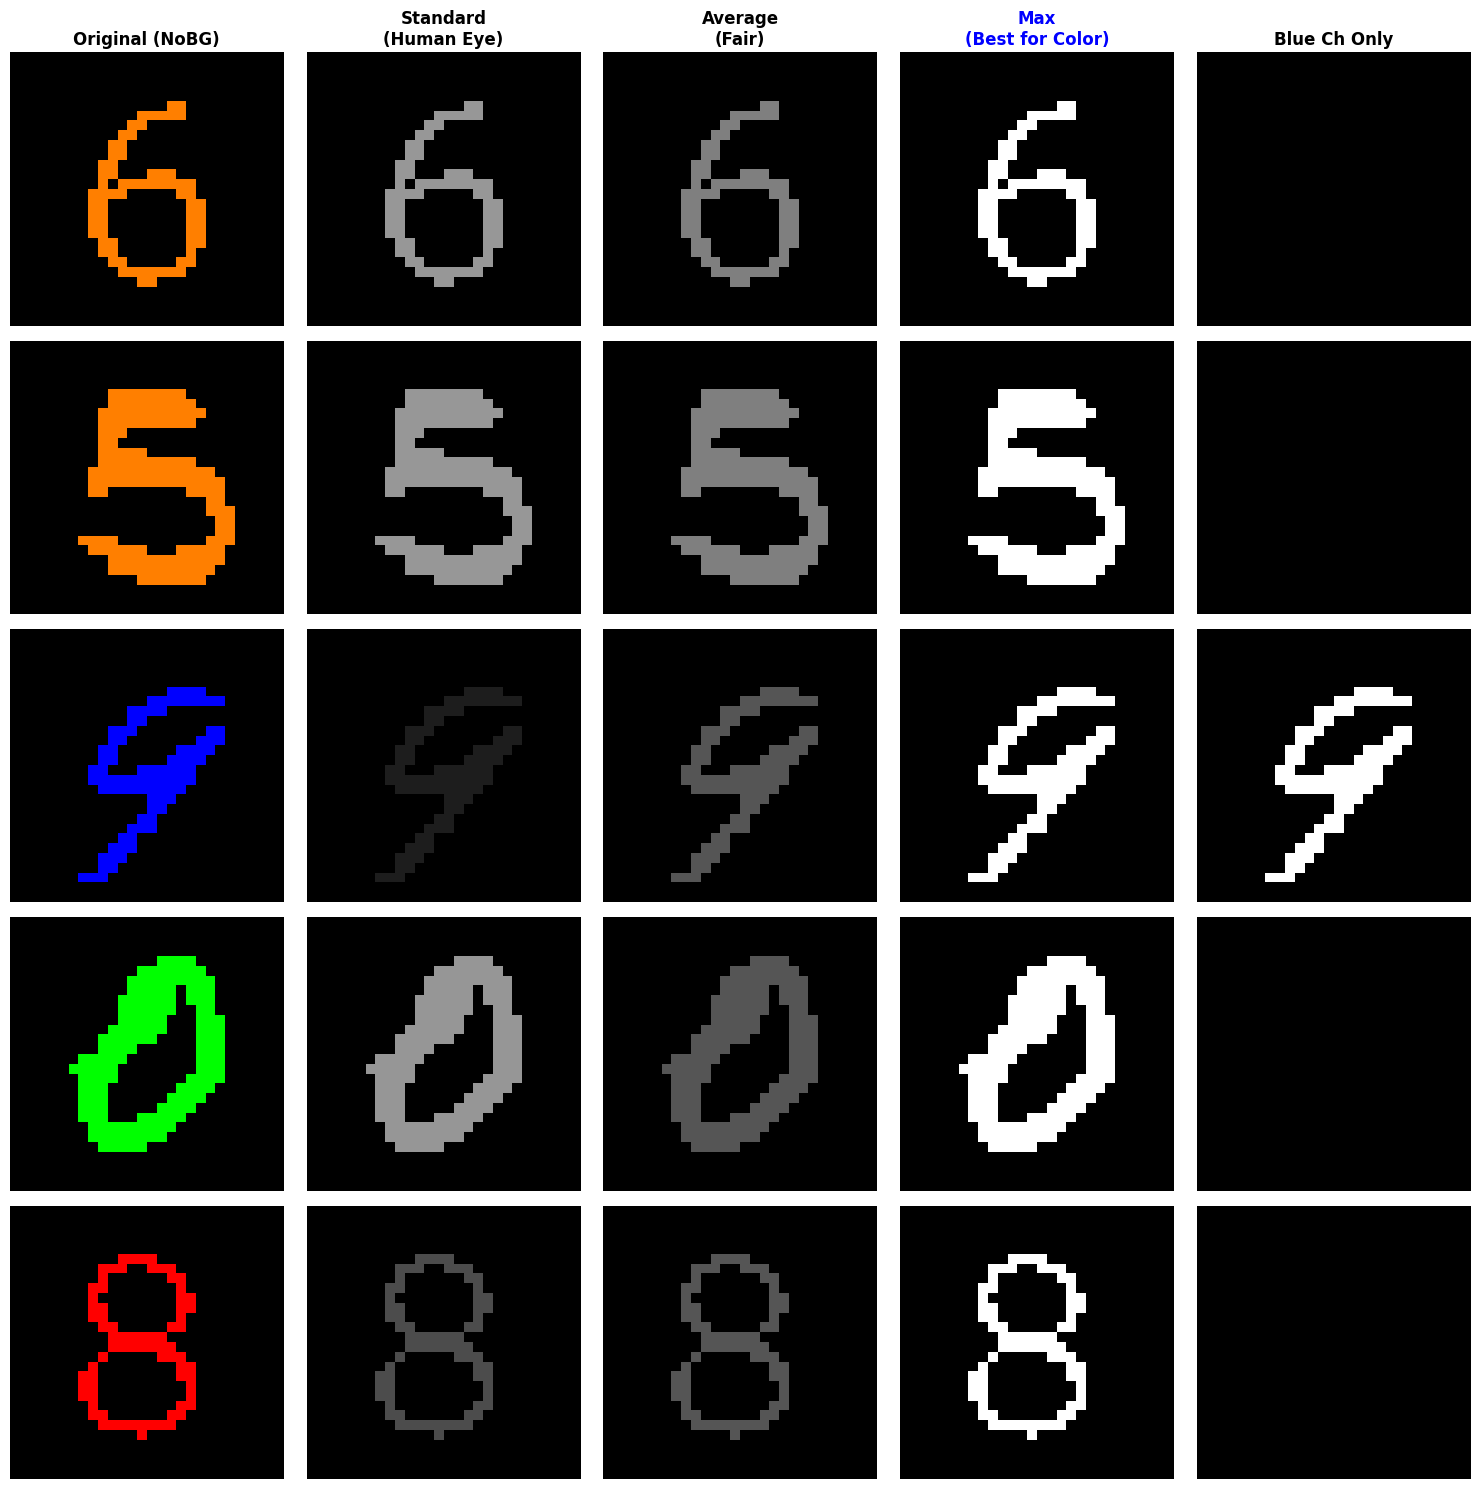

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def compare_grayscale_methods(images_rgb, num_samples=5):
    # 랜덤 샘플 추출
    idx = np.random.choice(len(images_rgb), num_samples, replace=False)
    samples = images_rgb[idx]
    
    # 1. Standard (0.299R + 0.587G + 0.114B)
    gray_std = np.dot(samples[...,:3], [0.299, 0.587, 0.114])
    
    # 2. Average ((R+G+B)/3)
    gray_avg = np.mean(samples[...,:3], axis=3)
    
    # 3. Max (max(R, G, B)) - 색상에 상관없이 가장 밝은 값
    gray_max = np.max(samples[...,:3], axis=3)
    
    # 4. Blue Channel Only (파란색 성분만 보기)
    # 파란색 숫자가 Standard에서 얼마나 어두워지는지 비교용
    gray_blue = samples[..., 2]

    # 시각화
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3 * num_samples))
    
    titles = ["Original (NoBG)", "Standard\n(Human Eye)", "Average\n(Fair)", "Max\n(Best for Color)", "Blue Ch Only"]
    
    for i in range(num_samples):
        # Original
        axes[i, 0].imshow(samples[i])
        axes[i, 0].axis('off')
        if i == 0: axes[i, 0].set_title(titles[0], fontweight='bold')
        
        # Standard
        axes[i, 1].imshow(gray_std[i], cmap='gray', vmin=0, vmax=1)
        axes[i, 1].axis('off')
        if i == 0: axes[i, 1].set_title(titles[1], fontweight='bold')
        
        # Average
        axes[i, 2].imshow(gray_avg[i], cmap='gray', vmin=0, vmax=1)
        axes[i, 2].axis('off')
        if i == 0: axes[i, 2].set_title(titles[2], fontweight='bold')
        
        # Max
        axes[i, 3].imshow(gray_max[i], cmap='gray', vmin=0, vmax=1)
        axes[i, 3].axis('off')
        if i == 0: axes[i, 3].set_title(titles[3], fontweight='bold', color='blue')
        
        # Blue
        axes[i, 4].imshow(gray_blue[i], cmap='gray', vmin=0, vmax=1)
        axes[i, 4].axis('off')
        if i == 0: axes[i, 4].set_title(titles[4], fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# 배경이 제거된 RGB 데이터(X_train_nobg)를 넣어서 확인해보세요
compare_grayscale_methods(X_train_nobg)

## 그레이스케일 작업

색상 분류용 데이터 (배경제거 Color): (60000, 2352)

배경 제거된 이미지 Grayscale 변환 중...
배경제거+Grayscale 학습 데이터 Shape: (60000, 28, 28)
배경제거+Grayscale 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale all 증강 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale rotate 증강 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale scale 증강 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale shear 증강 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale shift 증강 검증 데이터 Shape: (10000, 28, 28)
배경제거+Grayscale Flatten Shape (Train, Val): (60000, 784) (10000, 784)
배경제거+Grayscale Flatten Shape (all, rotate, scale, shear, shift): (10000, 784) (10000, 784) (10000, 784) (10000, 784) (10000, 784)


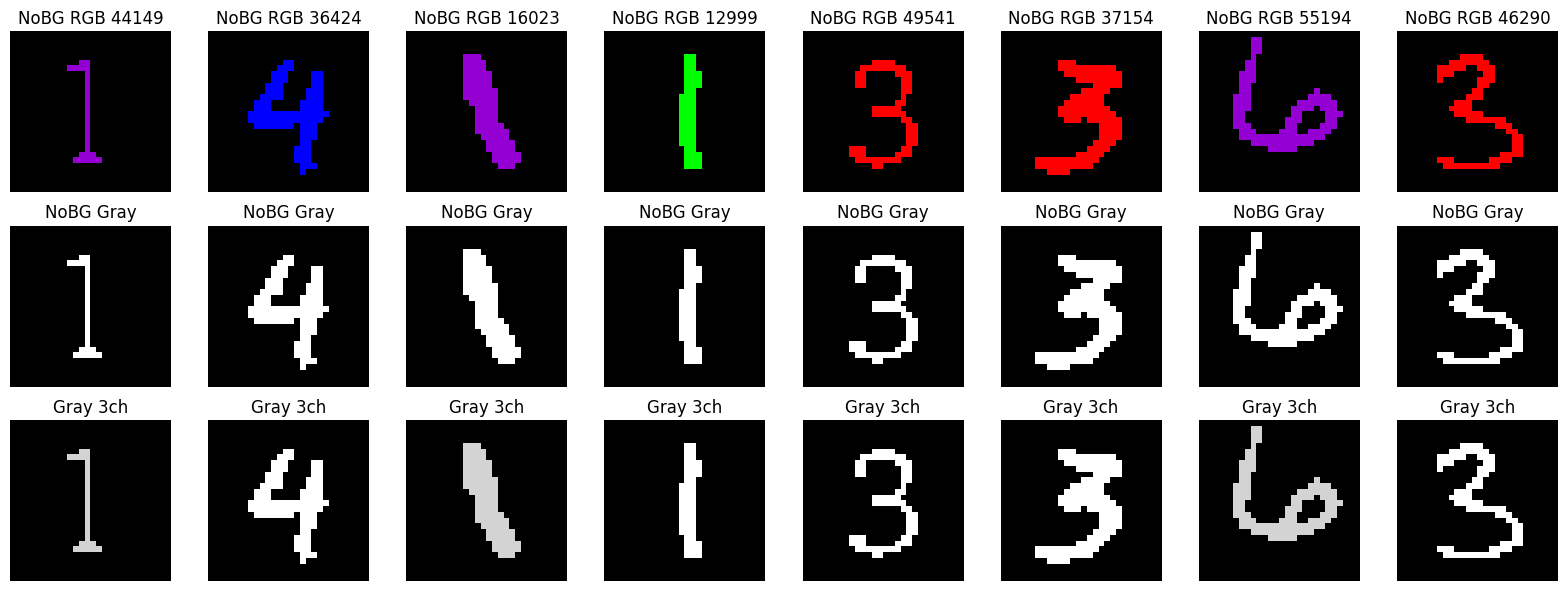

In [153]:
# (2) 배경 제거 버전 -> Flatten (Digit / FG Color 등에서 사용)
X_train_flat_nobg = X_train_nobg.reshape(X_train_nobg.shape[0], -1)
X_val_flat_nobg   = X_val_nobg.reshape(X_val_nobg.shape[0], -1)
X_val_all_flat_nobg = X_val_all_nobg.reshape(X_val_all_nobg.shape[0], -1)
X_val_rotate_flat_nobg = X_val_rotate_nobg.reshape(X_val_rotate_nobg.shape[0], -1)
X_val_scale_flat_nobg = X_val_scale_nobg.reshape(X_val_scale_nobg.shape[0], -1)
X_val_shear_flat_nobg = X_val_shear_nobg.reshape(X_val_shear_nobg.shape[0], -1)
X_val_shift_flat_nobg = X_val_shift_nobg.reshape(X_val_shift_nobg.shape[0], -1)
print(f"색상 분류용 데이터 (배경제거 Color): {X_train_flat_nobg.shape}")

# ===============================
# 5. 배경 제거 후 Grayscale 변환 (Digit 전용)
# ===============================
def rgb_to_gray(images):
    """
    images: (N, H, W, 3), 0~1 또는 0~255
    return: (N, H, W) float32 (0~1 스케일)
    """
    if images.max() > 1.0:
        imgs = images.astype(np.float32) / 255.0
    else:
        imgs = images.astype(np.float32)

    #gray = imgs.mean(axis=3)  # (N, H, W), R/G/B 평균 이게 그레이스케일 파라미터 조정
    gray = np.max(imgs, axis=3)
    return gray

print("\n배경 제거된 이미지 Grayscale 변환 중...")
X_train_nobg_gray = rgb_to_gray(X_train_nobg)
X_val_nobg_gray   = rgb_to_gray(X_val_nobg)
X_val_all_nobg_gray   = rgb_to_gray(X_val_all_nobg)
X_val_rotate_nobg_gray   = rgb_to_gray(X_val_rotate_nobg)
X_val_scale_nobg_gray   = rgb_to_gray(X_val_scale_nobg)
X_val_shear_nobg_gray   = rgb_to_gray(X_val_shear_nobg)
X_val_shift_nobg_gray   = rgb_to_gray(X_val_shift_nobg)

print("배경제거+Grayscale 학습 데이터 Shape:", X_train_nobg_gray.shape)
print("배경제거+Grayscale 검증 데이터 Shape:", X_val_nobg_gray.shape)
print("배경제거+Grayscale all 증강 검증 데이터 Shape:", X_val_all_nobg_gray.shape)
print("배경제거+Grayscale rotate 증강 검증 데이터 Shape:", X_val_rotate_nobg_gray.shape)
print("배경제거+Grayscale scale 증강 검증 데이터 Shape:", X_val_scale_nobg_gray.shape)
print("배경제거+Grayscale shear 증강 검증 데이터 Shape:", X_val_shear_nobg_gray.shape)
print("배경제거+Grayscale shift 증강 검증 데이터 Shape:", X_val_shift_nobg_gray.shape)

# Flatten (Digit 전용 입력)
X_train_flat_nobg_gray = X_train_nobg_gray.reshape(X_train_nobg_gray.shape[0], -1)
X_val_flat_nobg_gray   = X_val_nobg_gray.reshape(X_val_nobg_gray.shape[0], -1)
X_val_all_flat_nobg_gray = X_val_all_nobg_gray.reshape(X_val_all_nobg_gray.shape[0], -1)
X_val_rotate_flat_nobg_gray = X_val_rotate_nobg_gray.reshape(X_val_rotate_nobg_gray.shape[0], -1)
X_val_scale_flat_nobg_gray = X_val_scale_nobg_gray.reshape(X_val_scale_nobg_gray.shape[0], -1)
X_val_shear_flat_nobg_gray = X_val_shear_nobg_gray.reshape(X_val_shear_nobg_gray.shape[0], -1)
X_val_shift_flat_nobg_gray = X_val_shift_nobg_gray.reshape(X_val_shift_nobg_gray.shape[0], -1)
print("배경제거+Grayscale Flatten Shape (Train, Val):",
      X_train_flat_nobg_gray.shape, X_val_flat_nobg_gray.shape)

print("배경제거+Grayscale Flatten Shape (all, rotate, scale, shear, shift):",
      X_val_all_flat_nobg_gray.shape, X_val_rotate_flat_nobg_gray.shape, X_val_scale_flat_nobg_gray.shape, X_val_shear_flat_nobg_gray.shape, X_val_shift_flat_nobg_gray.shape)

# ===============================
# 6. 배경제거 + Grayscale 결과 시각화 (샘플 8개)
# ===============================
num_samples = 8
idx_gray = np.random.choice(X_train_nobg_gray.shape[0], num_samples, replace=False)

plt.figure(figsize=(16, 6))

for col, i in enumerate(idx_gray):
    # (1) 배경제거된 RGB 이미지
    ax1 = plt.subplot(3, num_samples, col + 1)
    ax1.imshow(X_train_nobg[i])
    ax1.axis('off')
    ax1.set_title(f"NoBG RGB {i}")

    # (2) Grayscale 이미지
    ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_nobg_gray[i], cmap='gray')
    ax2.axis('off')
    ax2.set_title("NoBG Gray")

    # (3) Grayscale 단일 채널을 3채널로 확장하여 확인 (선택적)
    ax3 = plt.subplot(3, num_samples, 2*num_samples + col + 1)
    ax3.imshow(np.repeat(X_train_nobg_gray[i][:,:,None], 3, axis=2), cmap='gray')
    ax3.axis('off')
    ax3.set_title("Gray 3ch")

plt.tight_layout()
plt.show()



## 배경제거+그레이스케일+이진화


Grayscale 이미지 이진화 적용 중 (Threshold=0.5)...
이진화 학습 데이터 Shape: (60000, 28, 28)
이진화 검증 데이터 Shape: (10000, 28, 28)
이진화 증강 검증 데이터 (all, rotate, scale, shear, shift): (10000, 28, 28) (10000, 28, 28) (10000, 28, 28) (10000, 28, 28) (10000, 28, 28)
이진화 Flatten Shape: (60000, 784)
이진화 증강 검증 데이터 flatten (all, rotate, scale, shear, shift): (10000, 784) (10000, 784) (10000, 784) (10000, 784) (10000, 784)


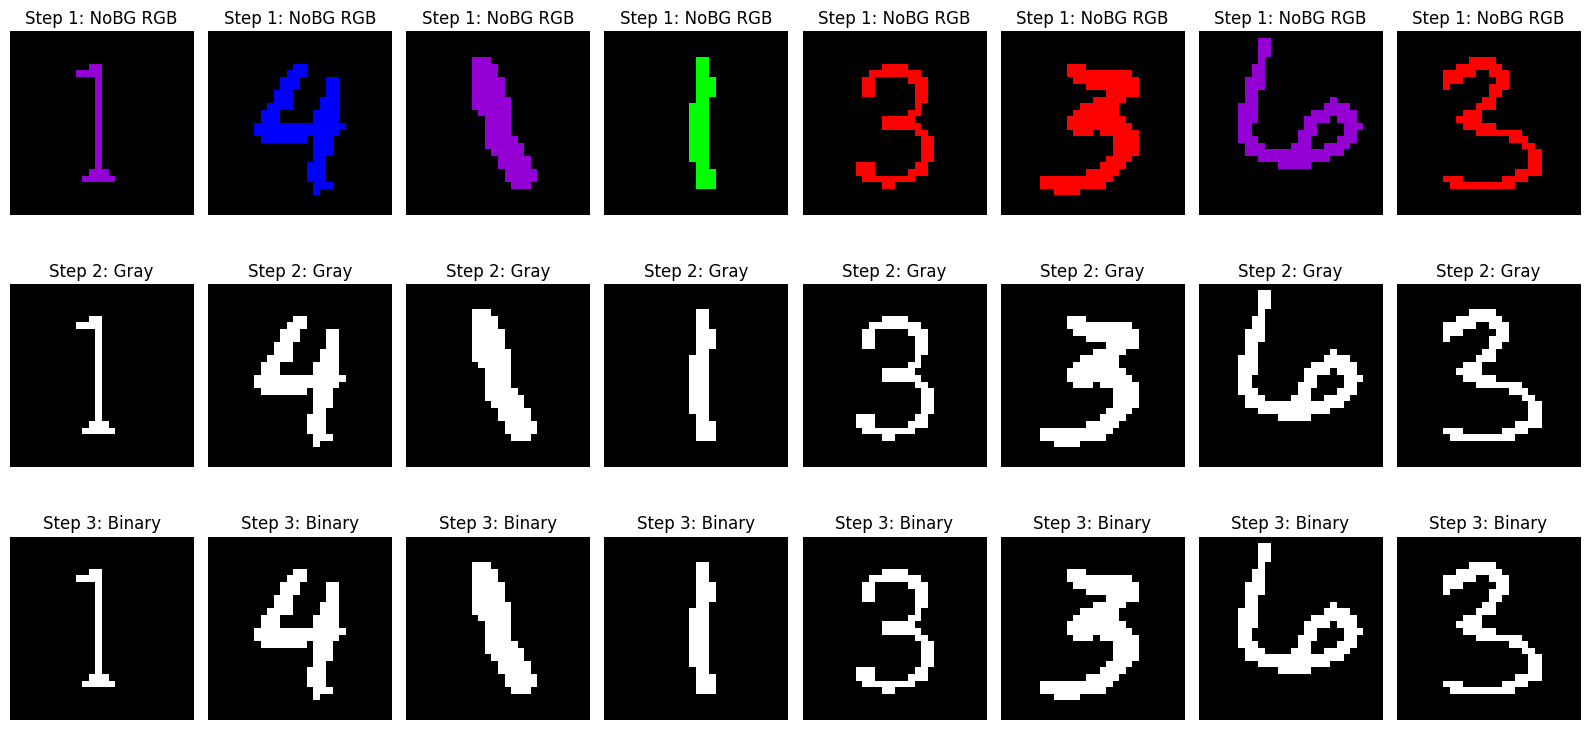

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 7. Grayscale -> Binarization (이진화)
# ===============================
# 임계값 (Threshold) 설정: 0.5를 기준으로 흑/백 나눔
# (상황에 따라 0.3이나 0.6 등으로 조절 가능)
THRESHOLD = 0.5

print(f"\nGrayscale 이미지 이진화 적용 중 (Threshold={THRESHOLD})...")

# 조건문 결과(True/False)를 float32(1.0/0.0)로 변환
X_train_bin = (X_train_nobg_gray > THRESHOLD).astype(np.float32)
X_val_bin   = (X_val_nobg_gray > THRESHOLD).astype(np.float32)
X_val_all_bin   = (X_val_all_nobg_gray > THRESHOLD).astype(np.float32)
X_val_rotate_bin   = (X_val_rotate_nobg_gray > THRESHOLD).astype(np.float32)
X_val_scale_bin   = (X_val_scale_nobg_gray > THRESHOLD).astype(np.float32)
X_val_shear_bin   = (X_val_shear_nobg_gray > THRESHOLD).astype(np.float32)
X_val_shift_bin   = (X_val_shift_nobg_gray > THRESHOLD).astype(np.float32)
print("이진화 학습 데이터 Shape:", X_train_bin.shape)
print("이진화 검증 데이터 Shape:", X_val_bin.shape)
print("이진화 증강 검증 데이터 (all, rotate, scale, shear, shift):",
      X_val_all_bin.shape, X_val_rotate_bin.shape, X_val_scale_bin.shape, X_val_shear_bin.shape, X_val_shift_bin.shape)
# Flatten (모델 입력용, 필요시 사용)
X_train_flat_bin = X_train_bin.reshape(X_train_bin.shape[0], -1)
X_val_flat_bin   = X_val_bin.reshape(X_val_bin.shape[0], -1)
X_val_all_flat_bin   = X_val_all_bin.reshape(X_val_all_bin.shape[0], -1)
X_val_rotate_flat_bin   = X_val_rotate_bin.reshape(X_val_rotate_bin.shape[0], -1)
X_val_scale_flat_bin   = X_val_scale_bin.reshape(X_val_scale_bin.shape[0], -1)
X_val_shear_flat_bin   = X_val_shear_bin.reshape(X_val_shear_bin.shape[0], -1)
X_val_shift_flat_bin   = X_val_shift_bin.reshape(X_val_shift_bin.shape[0], -1)
print("이진화 Flatten Shape:", X_train_flat_bin.shape)
print("이진화 증강 검증 데이터 flatten (all, rotate, scale, shear, shift):",
      X_val_all_flat_bin.shape, X_val_rotate_flat_bin.shape, X_val_scale_flat_bin.shape, X_val_shear_flat_bin.shape, X_val_shift_flat_bin.shape)

# ===============================
# 8. 전체 변환 과정 시각화 (RGB -> Gray -> Binary)
# ===============================
# 앞서 사용했던 인덱스(idx_gray)를 그대로 사용해서 변화 과정을 비교합니다.
# (만약 이전 셀의 변수가 없다면 새로 랜덤하게 뽑습니다)
if 'idx_gray' not in locals():
    num_samples = 8
    idx_gray = np.random.choice(X_train_nobg_gray.shape[0], num_samples, replace=False)

plt.figure(figsize=(16, 8)) # 3줄을 표현해야 하므로 세로 길이를 늘립니다.

for col, i in enumerate(idx_gray):
    # (1) 배경제거 RGB (1행)
    ax1 = plt.subplot(3, num_samples, col + 1)
    ax1.imshow(X_train_nobg[i])
    ax1.axis('off')
    ax1.set_title("Step 1: NoBG RGB")

    # (2) Grayscale (2행)
    ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_nobg_gray[i], cmap='gray')
    ax2.axis('off')
    ax2.set_title("Step 2: Gray")

    # (3) Binarization (3행)
    ax3 = plt.subplot(3, num_samples, 2 * num_samples + col + 1)
    ax3.imshow(X_train_bin[i], cmap='gray')
    ax3.axis('off')
    ax3.set_title(f"Step 3: Binary")

plt.tight_layout()
plt.show()

## 변환과정 확인

새로 뽑은 이미지 인덱스: [58336 58419 47450 28826 10213  5538 28922  2685]


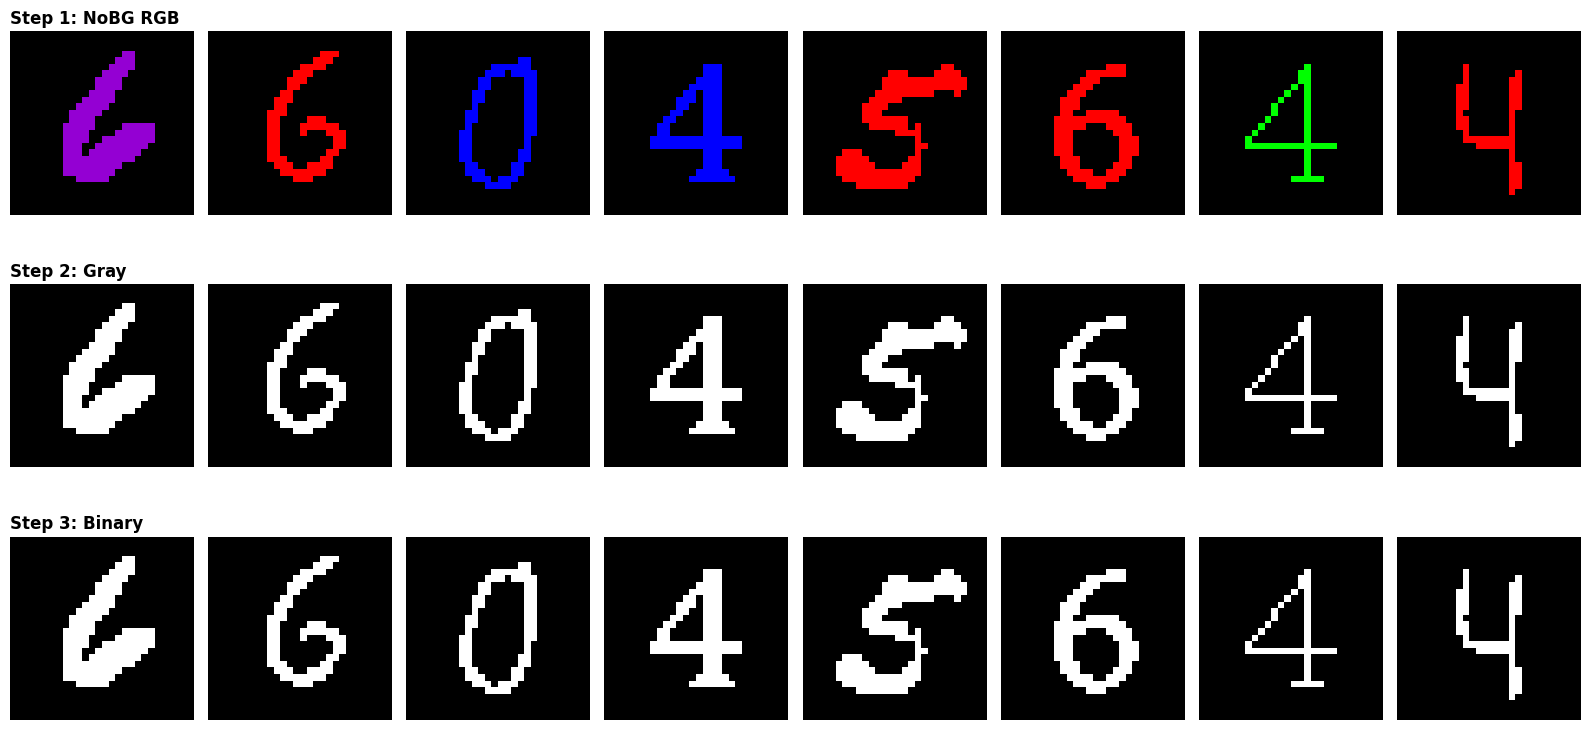

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 8. 전체 변환 과정 시각화 (매번 새로운 이미지)
# ===============================

# 1. 매번 실행할 때마다 새로운 랜덤 인덱스 8개 뽑기
num_samples = 8
# 전체 데이터 개수 범위 내에서 무작위 추출
random_indices = np.random.choice(len(X_train_nobg_gray), num_samples, replace=False)

print(f"새로 뽑은 이미지 인덱스: {random_indices}")

plt.figure(figsize=(16, 8)) # 3줄 표현 (배경제거 RGB -> Gray -> Binary)

for col, i in enumerate(random_indices):
    # (1) 배경제거 RGB (1행)
    ax1 = plt.subplot(3, num_samples, col + 1)
    ax1.imshow(X_train_nobg[i])
    ax1.axis('off')
    if col == 0: ax1.set_title("Step 1: NoBG RGB", fontsize=12, fontweight='bold', loc='left')

    # (2) Grayscale (2행)
    ax2 = plt.subplot(3, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_nobg_gray[i], cmap='gray')
    ax2.axis('off')
    if col == 0: ax2.set_title("Step 2: Gray", fontsize=12, fontweight='bold', loc='left')

    # (3) Binarization (3행)
    ax3 = plt.subplot(3, num_samples, 2 * num_samples + col + 1)
    ax3.imshow(X_train_bin[i], cmap='gray')
    ax3.axis('off')
    if col == 0: ax3.set_title("Step 3: Binary", fontsize=12, fontweight='bold', loc='left')

plt.tight_layout()
plt.show()

## 배경제거+그레이스케일 픽셀 밝기 분포 확인

픽셀 밝기 분포 분석 중...


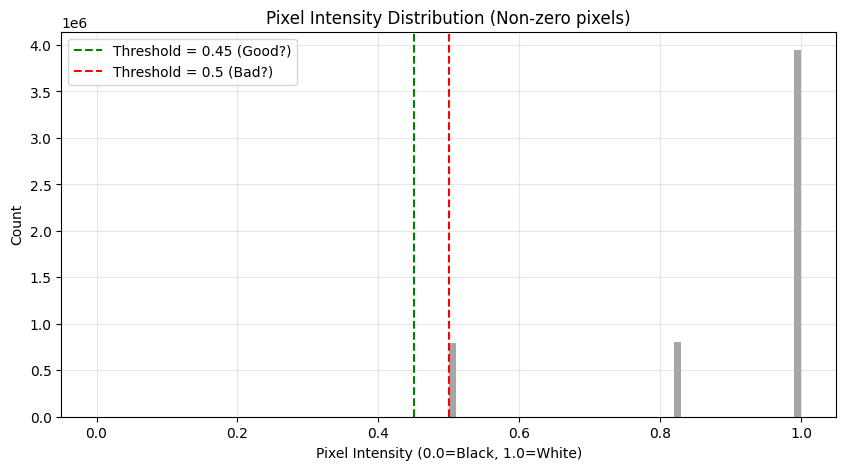

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pixel_histogram(images, sample_count=60000):
    """
    이미지 픽셀 밝기 분포(Histogram)를 그려서 최적의 Threshold를 찾습니다.
    """
    print("픽셀 밝기 분포 분석 중...")
    
    # 속도를 위해 샘플링 (1000장만)
    idx = np.random.choice(len(images), sample_count, replace=False)
    sampled_imgs = images[idx]
    
    # 모든 픽셀을 1차원으로 쫘악 펴기
    pixel_values = sampled_imgs.flatten()
    
    # 0(완전 검은 배경)은 너무 많아서 그래프를 망치므로 제외하고,
    # 0보다 큰 값(글씨+노이즈)만 봅니다.
    pixel_values_nonzero = pixel_values[pixel_values > 0.01]
    
    plt.figure(figsize=(10, 5))
    plt.hist(pixel_values_nonzero, bins=100, range=(0.0, 1.0), color='gray', alpha=0.7)
    
    # 사용자가 고민했던 0.2와 0.3 지점 표시
    plt.axvline(0.45, color='green', linestyle='--', label='Threshold = 0.45 (Good?)')
    plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5 (Bad?)')
    
    plt.title("Pixel Intensity Distribution (Non-zero pixels)")
    plt.xlabel("Pixel Intensity (0.0=Black, 1.0=White)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 배경제거+그레이스케일 된 데이터(X_train_nobg_gray)를 넣어보세요
plot_pixel_histogram(X_train_nobg_gray)

>>> 전체 데이터 60000장의 0.1 ~ 0.3 구간 정밀 분석 중...
   -> 해당 구간 픽셀 수: 798,423개


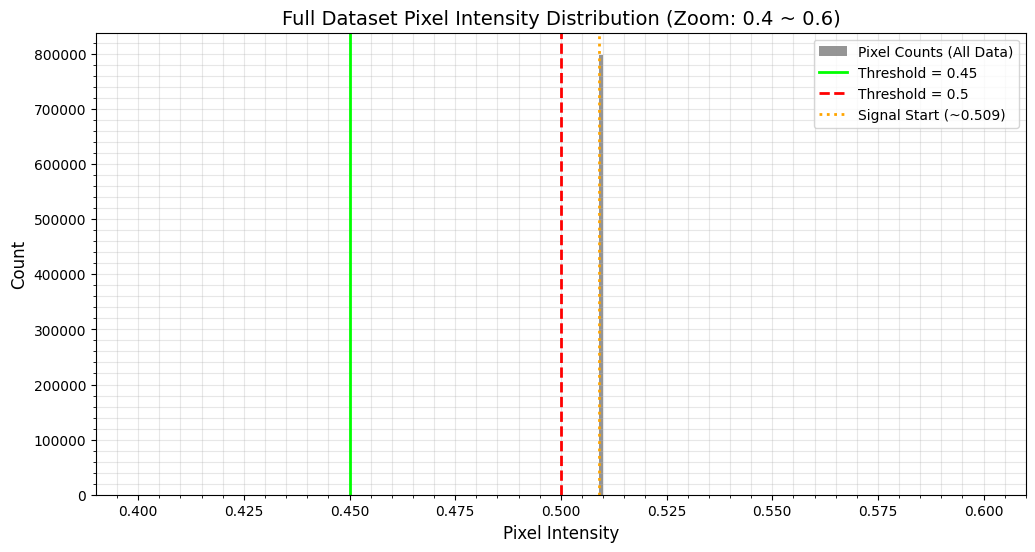

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def plot_zoomed_histogram_all(images):
    """
    샘플링 없이 전체 데이터(60,000장)의 0.1 ~ 0.3 구간 픽셀 분포를 확인합니다.
    """
    print(f">>> 전체 데이터 {len(images)}장의 0.1 ~ 0.3 구간 정밀 분석 중...")
    
    # 1. 샘플링 과정 생략 -> 전체 데이터를 1차원으로 펼치기
    # (N, 28, 28) -> (N * 784,)
    pixel_values = images.flatten()
    
    # 2. 0.1 ~ 0.3 사이 값만 필터링 (메모리 절약 및 속도 향상)
    # 전체 4700만 개 픽셀 중 해당 구간만 남깁니다.
    zoom_range_mask = (pixel_values >= 0.4) & (pixel_values <= 0.6)
    pixel_values_zoomed = pixel_values[zoom_range_mask]
    
    print(f"   -> 해당 구간 픽셀 수: {len(pixel_values_zoomed):,}개")
    
    plt.figure(figsize=(12, 6))
    
    # 3. 히스토그램 그리기
    # bins=200으로 더 잘게 쪼개서 0.001 단위의 변화까지 봅니다.
    counts, _, _ = plt.hist(pixel_values_zoomed, bins=200, range=(0.4, 0.6), 
                            color='dimgray', alpha=0.7, label='Pixel Counts (All Data)')
    
    # 주요 지점 표시
    plt.axvline(0.45, color='lime', linestyle='-', linewidth=2, label='Threshold = 0.45')
    plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
    
    # 0.25 지점 강조 (데이터 시작점 추정)
    plt.axvline(0.509, color='orange', linestyle=':', linewidth=2, label='Signal Start (~0.509)')
    
    plt.title(f"Full Dataset Pixel Intensity Distribution (Zoom: 0.4 ~ 0.6)", fontsize=14)
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3, which='both')
    plt.minorticks_on()
    
    plt.show()

# 전체 데이터(X_train_nobg_gray)를 넣어서 실행하세요
plot_zoomed_histogram_all(X_train_nobg_gray)

## 배경제거+그레이스케일 학습

In [82]:
print("\n--- 3종 모델 학습 시작 (배경제거+Grayscale, Digit 전용) ---")

training_jobs_nobg_gray = [
    # 1. RandomForest - Digit (NoBG+Gray)
    ("RandomForest - Digit (NoBG+Gray)",
     cuRF(n_estimators=100, max_depth=16, random_state=42),
     X_train_flat_nobg_gray, y_train_digit),

    # 2. XGBoost - Digit (NoBG+Gray)
    ("XGBoost - Digit (NoBG+Gray)",
     xgb.XGBClassifier(
         n_estimators=100, tree_method='hist', device='cuda', 
            objective='multi:softmax', num_class=10, random_state=42
     ),
     X_train_flat_nobg_gray, y_train_digit),

    # 3. LightGBM - Digit (NoBG+Gray)
    ("LightGBM - Digit (NoBG+Gray)",
     lgb.LGBMClassifier(
         n_estimators=100, device='cuda', objective='multiclass', 
            num_class=10, random_state=42, verbose=-1
     ),
     X_train_flat_nobg_gray, y_train_digit),
]

trained_models_nobg_gray = {}

for name, model, X_train_data, y_train_data in tqdm(training_jobs_nobg_gray,
                                                    desc="NoBG+Gray Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models_nobg_gray[name] = model

print("\n--- 배경 제거+Grayscale 기반 Digit 모델 3종 학습 완료 ---")



--- 3종 모델 학습 시작 (배경제거+Grayscale, Digit 전용) ---


NoBG+Gray Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


--- 배경 제거+Grayscale 기반 Digit 모델 3종 학습 완료 ---


## 배경제거+그레이스케일 성능평가

In [83]:
def evaluate_model_nobg_gray(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 1. 검증 데이터 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_nobg_gray, y_val_digit

    # 2. 예측 (cuRF만 GPU->CPU 변환 처리)
    if "cuRF" in model_name:
        import cupy as cp
        # cuRF는 GPU 배열 입력 권장
        X_val_gpu = cp.asarray(X_val)
        # 결과가 GPU 배열이므로 .get()으로 CPU로 가져옵니다
        y_pred = model_obj.predict(X_val_gpu).get()
        y_proba = model_obj.predict_proba(X_val_gpu).get()
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        y_proba = model_obj.predict_proba(X_val)

    # 3. 결과 출력 (님이 원하신 sklearn 함수 사용)
    print(sk_classification_report(y_val, y_pred, digits=4))
    
    try:
        auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
        print(f"** Weighted-Average AUC: {auc:.4f} **")
    except Exception as e:
        print(f"AUC 계산 중 오류: {e}")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models_nobg_gray.items():
    evaluate_model_nobg_gray(name, model)


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit (NoBG+Gray) =====
              precision    recall  f1-score   support

         0.0     0.9888    0.9959    0.9923       972
         1.0     0.9769    0.9961    0.9864      1021
         2.0     0.9785    0.9681    0.9732       939
         3.0     0.9843    0.9672    0.9757       975
         4.0     0.9812    0.9773    0.9793      1015
         5.0     0.9758    0.9806    0.9782      1029
         6.0     0.9865    0.9922    0.9894      1032
         7.0     0.9796    0.9786    0.9791       980
         8.0     0.9821    0.9667    0.9744      1022
         9.0     0.9688    0.9783    0.9735      1015

    accuracy                         0.9802     10000
   macro avg     0.9803    0.9801    0.9801     10000
weighted avg     0.9802    0.9802    0.9802     10000

** Weighted-Average AUC: 0.9997 **

===== XGBoost - Digit (NoBG+Gray) =====
              precision    recall  f1-score   support

         0.0     0.9898    0.

## 배경제거+그레이스케일+0.25 이진화 학습

--- [Step 1] 이진화 데이터 Flatten (2D -> 1D) ---
학습 데이터 Shape: (60000, 784)
검증 데이터 Shape: (10000, 784)

--- [Step 2] 모델 학습 시작 (Input: Binary Raw Pixels) ---


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (Binary Pixels) 학습 중...
   -> XGBoost (Binary Pixels) 학습 중...
   -> LightGBM (Binary Pixels) 학습 중...

✅ 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

===== RandomForest (Binary Pixels) =====
              precision    recall  f1-score   support

         0.0     0.9898    0.9949    0.9923       972
         1.0     0.9826    0.9980    0.9903      1021
         2.0     0.9806    0.9712    0.9759       939
         3.0     0.9823    0.9703    0.9763       975
         4.0     0.9881    0.9793    0.9837      1015
         5.0     0.9805    0.9796    0.9801      1029
         6.0     0.9894    0.9952    0.9923      1032
         7.0     0.9826    0.9816    0.9821       980
         8.0     0.9872    0.9795    0.9833      1022
         9.0     0.9737    0.9862    0.9799      1015

    accuracy                         0.9837     10000
   macro avg     0.9837    0.9836    0.9836     10000
weighted avg     0.9837    0.9837    0.9837     10000

   -> Accuracy: 0.9837

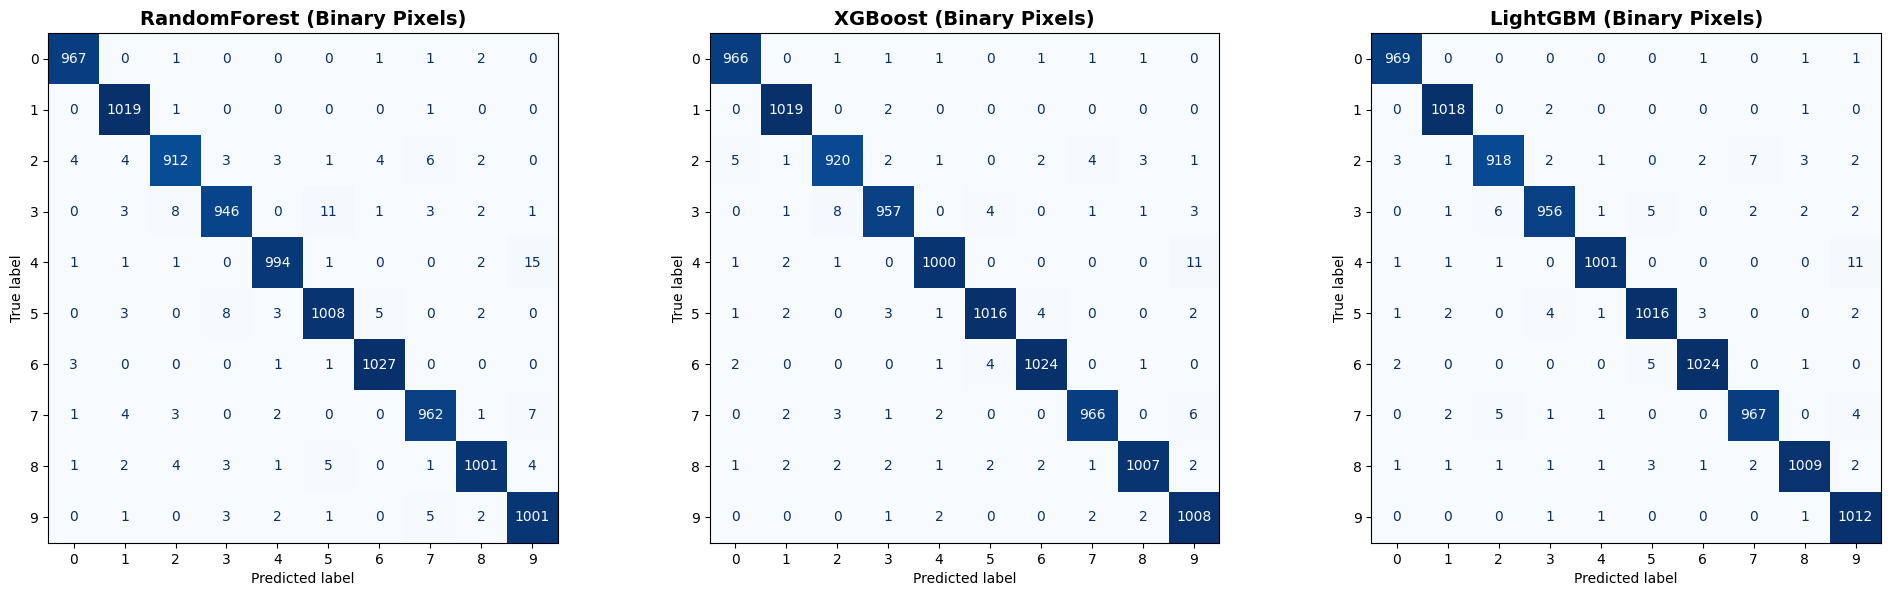

In [84]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("--- [Step 1] 이진화 데이터 Flatten (2D -> 1D) ---")

# (N, 28, 28) -> (N, 784)
X_train_flat_bin = X_train_bin.reshape(X_train_bin.shape[0], -1)
X_val_flat_bin   = X_val_bin.reshape(X_val_bin.shape[0], -1)

print(f"학습 데이터 Shape: {X_train_flat_bin.shape}")
print(f"검증 데이터 Shape: {X_val_flat_bin.shape}")

print("\n--- [Step 2] 모델 학습 시작 (Input: Binary Raw Pixels) ---")

training_jobs_raw = [
    # 1. RandomForest
    ("RandomForest (Binary Pixels)",
     cuRF(n_estimators=100, max_depth=16, random_state=42),
     X_train_flat_bin, y_train_digit),

    # 2. XGBoost
    ("XGBoost (Binary Pixels)",
     xgb.XGBClassifier(
         n_estimators=100, tree_method='hist', device='cuda', 
         objective='multi:softmax', num_class=10, random_state=42
     ),
     X_train_flat_bin, y_train_digit),

    # 3. LightGBM
    ("LightGBM (Binary Pixels)",
     lgb.LGBMClassifier(
         n_estimators=100, device='cuda', objective='multiclass', 
         num_class=10, random_state=42, verbose=-1
     ),
     X_train_flat_bin, y_train_digit),
]

trained_models_raw = {}

for name, model, X_tr, y_tr in tqdm(training_jobs_raw, desc="Training Progress"):
    print(f"   -> {name} 학습 중...")
    model.fit(X_tr, y_tr)
    trained_models_raw[name] = model

print("\n✅ 모델 학습 완료!")

print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

def evaluate_model_raw(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")

    # 예측 (cuRF GPU 처리 포함)
    y_pred = None
    y_proba = None
    
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)
        
        # 예측
        raw_pred = model_obj.predict(X_val_gpu)
        y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred
            
        # 확률
        try:
            raw_proba = model_obj.predict_proba(X_val_gpu)
            y_proba = raw_proba.get() if hasattr(raw_proba, 'get') else raw_proba
        except AttributeError:
            y_proba = None
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        try:
            y_proba = model_obj.predict_proba(X_val)
        except AttributeError:
            y_proba = None

    # 결과 출력
    if y_pred is not None:
        print(classification_report(y_val, y_pred, digits=4))
        acc = accuracy_score(y_val, y_pred)
        print(f"   -> Accuracy: {acc:.4f}")
    
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"   -> Weighted AUC: {auc:.4f}")
        except Exception as e:
            print(f"   -> AUC Error: {e}")
            
    return y_pred # Confusion Matrix를 위해 반환

# --- Confusion Matrix 시각화 ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes = axes.flatten()

for i, (name, model) in enumerate(trained_models_raw.items()):
    # 평가 및 예측값 획득
    y_pred = evaluate_model_raw(name, model, X_val_flat_bin, y_val_digit)
    
    # 시각화
    cm = confusion_matrix(y_val_digit, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 배경제거+그레이스케일+이진화+HOG

In [140]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from cuml.ensemble import RandomForestClassifier as cuRF
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# =========================================================
# 1. HOG 피처 추출 (Input: X_train_bin, X_val_bin)
# =========================================================
print("--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---")

def extract_hog_from_binary(images):
    hog_list = []
    # 파라미터: 4x4 cell (이진화된 이미지의 거친 엣지를 세밀하게 포착)
    ppc = 4
    cpb = 2 
    
    for img in tqdm(images, desc="HOG Extraction"):
        # visualize=False -> 벡터만 추출
        feat = hog(img, pixels_per_cell=(ppc, ppc), 
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
    return np.array(hog_list, dtype=np.float32)

# 사용자가 지정한 변수(X_train_bin, X_val_bin) 사용
print("1. 학습 데이터(X_train_bin) HOG 변환 중...")
X_train_hog = extract_hog_from_binary(X_train_bin)

print("2. 검증 데이터(X_val_bin) HOG 변환 중...")
X_val_hog = extract_hog_from_binary(X_val_bin)

print(f"   -> Final HOG Feature Shape: {X_train_hog.shape}")


# =========================================================
# 2. 모델 학습 (3종: RF, XGB, LGBM)
# =========================================================
print("\n--- [Step 2] 모델 학습 시작 (HOG Features) ---")

training_jobs = [
    # 1. RandomForest
    ("RandomForest (HOG+Bin)", 
     cuRF(n_estimators=100, max_depth=16, random_state=42), 
     X_train_hog, y_train_digit),

    # 2. XGBoost
    ("XGBoost (HOG+Bin)", 
     xgb.XGBClassifier(n_estimators=100, tree_method='hist', device='cuda', 
                       objective='multi:softmax', num_class=10, random_state=42), 
     X_train_hog, y_train_digit),

    # 3. LightGBM
    ("LightGBM (HOG+Bin)", 
     lgb.LGBMClassifier(n_estimators=100, device='cuda', objective='multiclass', 
                        num_class=10, random_state=42, verbose=-1), 
     X_train_hog, y_train_digit),
]

trained_models_hog = {}

for name, model, X_tr, y_tr in tqdm(training_jobs, desc="Training Models"):
    print(f"   -> {name} 학습 중...")
    model.fit(X_tr, y_tr)
    trained_models_hog[name] = model

print("✅ 모든 모델 학습 완료!")


# =========================================================
# 3. 최종 성능 평가
# =========================================================
print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

def evaluate_model(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")
    
    y_pred = None
    y_proba = None
    
    # cuRF (GPU) 처리
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)
        
        # 예측값
        raw_pred = model_obj.predict(X_val_gpu)
        y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred
        
        # 확률값 (AUC용)
        try:
            raw_proba = model_obj.predict_proba(X_val_gpu)
            y_proba = raw_proba.get() if hasattr(raw_proba, 'get') else raw_proba
        except AttributeError:
            y_proba = None
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        try:
            y_proba = model_obj.predict_proba(X_val)
        except AttributeError:
            y_proba = None
        
    # 결과 출력
    if y_pred is not None:
        print(classification_report(y_val, y_pred, digits=4))
        print(f"   -> Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"   -> Weighted AUC: {auc:.4f}")
        except Exception as e:
            print(f"   -> AUC Error: {e}")

# 평가 실행 (X_val_hog 사용)
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_hog, y_val_digit)

--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---
1. 학습 데이터(X_train_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/60000 [00:00<?, ?it/s]

2. 검증 데이터(X_val_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

   -> Final HOG Feature Shape: (60000, 1296)

--- [Step 2] 모델 학습 시작 (HOG Features) ---


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (HOG+Bin) 학습 중...
   -> XGBoost (HOG+Bin) 학습 중...
   -> LightGBM (HOG+Bin) 학습 중...
✅ 모든 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

===== RandomForest (HOG+Bin) =====
              precision    recall  f1-score   support

         0.0     0.9939    0.9990    0.9964       972
         1.0     0.9961    0.9931    0.9946      1021
         2.0     0.9852    0.9894    0.9872       939
         3.0     0.9816    0.9826    0.9821       975
         4.0     0.9911    0.9823    0.9866      1015
         5.0     0.9892    0.9835    0.9864      1029
         6.0     0.9923    0.9932    0.9927      1032
         7.0     0.9878    0.9898    0.9888       980
         8.0     0.9921    0.9853    0.9887      1022
         9.0     0.9815    0.9931    0.9873      1015

    accuracy                         0.9891     10000
   macro avg     0.9891    0.9891    0.9891     10000
weighted avg     0.9891    0.9891    0.9891     10000

   -> Accuracy: 0.9891
   -> Weighted AUC: 0

## Robustness 평가

In [156]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from cuml.ensemble import RandomForestClassifier as cuRF
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# =========================================================
# 1. HOG 피처 추출 (Input: X_train_bin, X_val_bin, 증강 검증 데이터들)
# =========================================================
print("--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---")

def extract_hog_from_binary(images):
    hog_list = []
    # 파라미터: 4x4 cell (이진화된 이미지의 거친 엣지를 세밀하게 포착)
    ppc = 4
    cpb = 2 
    
    for img in tqdm(images, desc="HOG Extraction"):
        # visualize=False -> 벡터만 추출
        feat = hog(img, pixels_per_cell=(ppc, ppc), 
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
    return np.array(hog_list, dtype=np.float32)

# 사용자가 지정한 변수(X_train_bin, X_val_bin) 사용
print("1. 학습 데이터(X_train_bin) HOG 변환 중...")
X_train_hog = extract_hog_from_binary(X_train_bin)

print("2. 검증 데이터(X_val_bin) HOG 변환 중...")
X_val_hog = extract_hog_from_binary(X_val_bin)

print("3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...")
X_val_all_hog = extract_hog_from_binary(X_val_all_bin)

print("4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...")
X_val_rotate_hog = extract_hog_from_binary(X_val_rotate_bin)

print("5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...")
X_val_scale_hog = extract_hog_from_binary(X_val_scale_bin)

print("6. 장긍 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...")
X_val_shear_hog = extract_hog_from_binary(X_val_shear_bin)

print("7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...")
X_val_shift_hog = extract_hog_from_binary(X_val_shift_bin)

print(f"   -> Final HOG Feature Shape: {X_train_hog.shape}")


# =========================================================
# 2. 모델 학습 (3종: RF, XGB, LGBM)
# =========================================================
print("\n--- [Step 2] 모델 학습 시작 (HOG Features) ---")

training_jobs = [
    # 1. RandomForest
    ("RandomForest (HOG+Bin)", 
     cuRF(n_estimators=100, max_depth=16, random_state=42), 
     X_train_hog, y_train_digit),

    # 2. XGBoost
    ("XGBoost (HOG+Bin)", 
     xgb.XGBClassifier(n_estimators=100, tree_method='hist', device='cuda', 
                       objective='multi:softmax', num_class=10, random_state=42), 
     X_train_hog, y_train_digit),

    # 3. LightGBM
    ("LightGBM (HOG+Bin)", 
     lgb.LGBMClassifier(n_estimators=100, device='cuda', objective='multiclass', 
                        num_class=10, random_state=42, verbose=-1), 
     X_train_hog, y_train_digit),
]

trained_models_hog = {}

for name, model, X_tr, y_tr in tqdm(training_jobs, desc="Training Models"):
    print(f"   -> {name} 학습 중...")
    model.fit(X_tr, y_tr)
    trained_models_hog[name] = model

print("✅ 모든 모델 학습 완료!")


# =========================================================
# 3. 최종 성능 평가
# =========================================================
print("\n--- [Step 3] 최종 성능 평가 (Validation Set) ---")

def evaluate_model(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")
    
    y_pred = None
    y_proba = None
    
    # cuRF (GPU) 처리
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)
        
        # 예측값
        raw_pred = model_obj.predict(X_val_gpu)
        y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred
        
        # 확률값 (AUC용)
        try:
            raw_proba = model_obj.predict_proba(X_val_gpu)
            y_proba = raw_proba.get() if hasattr(raw_proba, 'get') else raw_proba
        except AttributeError:
            y_proba = None
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        try:
            y_proba = model_obj.predict_proba(X_val)
        except AttributeError:
            y_proba = None
        
    # 결과 출력
    if y_pred is not None:
        print(classification_report(y_val, y_pred, digits=4))
        print(f"   -> Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"   -> Weighted AUC: {auc:.4f}")
        except Exception as e:
            print(f"   -> AUC Error: {e}")

# 평가 실행 (X_val_hog 사용)
print("\n1. 기본 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_hog, y_val_digit)
    
print("\n2. 증강 all 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_all_hog, y_val_all_digit)
    
print("\n3. 증강 rotate 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_rotate_hog, y_val_rotate_digit)
    
print("\n4. 증강 scale 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_scale_hog, y_val_scale_digit)
    
print("\n5. 증강 shear 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_shear_hog, y_val_shear_digit) 
    
print("\n6. 증강 shift 검증 데이터로 평가\n")
for name, model in trained_models_hog.items():
    evaluate_model(name, model, X_val_shift_hog, y_val_shift_digit) 

--- [Step 1] HOG 피처 추출 시작 (Input: Binary Image) ---
1. 학습 데이터(X_train_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/60000 [00:00<?, ?it/s]

2. 검증 데이터(X_val_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

3. 증강 all 검증 데이터(X_val_all_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

4. 증강 rotate 검증 데이터(X_val_rotate_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

5. 증강 scale 검증 데이터(X_val_scale_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

6. 장긍 shear 검증 데이터(X_val_shear_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

7. 증강 shift 검증 데이터(X_val_shift_bin) HOG 변환 중...


HOG Extraction:   0%|          | 0/10000 [00:00<?, ?it/s]

   -> Final HOG Feature Shape: (60000, 1296)

--- [Step 2] 모델 학습 시작 (HOG Features) ---


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

   -> RandomForest (HOG+Bin) 학습 중...
   -> XGBoost (HOG+Bin) 학습 중...
   -> LightGBM (HOG+Bin) 학습 중...
✅ 모든 모델 학습 완료!

--- [Step 3] 최종 성능 평가 (Validation Set) ---

1. 기본 검증 데이터로 평가


===== RandomForest (HOG+Bin) =====
              precision    recall  f1-score   support

         0.0     0.9939    0.9990    0.9964       972
         1.0     0.9961    0.9931    0.9946      1021
         2.0     0.9852    0.9894    0.9872       939
         3.0     0.9816    0.9826    0.9821       975
         4.0     0.9911    0.9823    0.9866      1015
         5.0     0.9892    0.9835    0.9864      1029
         6.0     0.9923    0.9932    0.9927      1032
         7.0     0.9878    0.9898    0.9888       980
         8.0     0.9921    0.9853    0.9887      1022
         9.0     0.9815    0.9931    0.9873      1015

    accuracy                         0.9891     10000
   macro avg     0.9891    0.9891    0.9891     10000
weighted avg     0.9891    0.9891    0.9891     10000

   -> Accuracy: 0.9891
  

## confusion matrix 배경제거, 그레이스케일, 이진화, hog


--- [Step 4] Confusion Matrix 시각화 ---


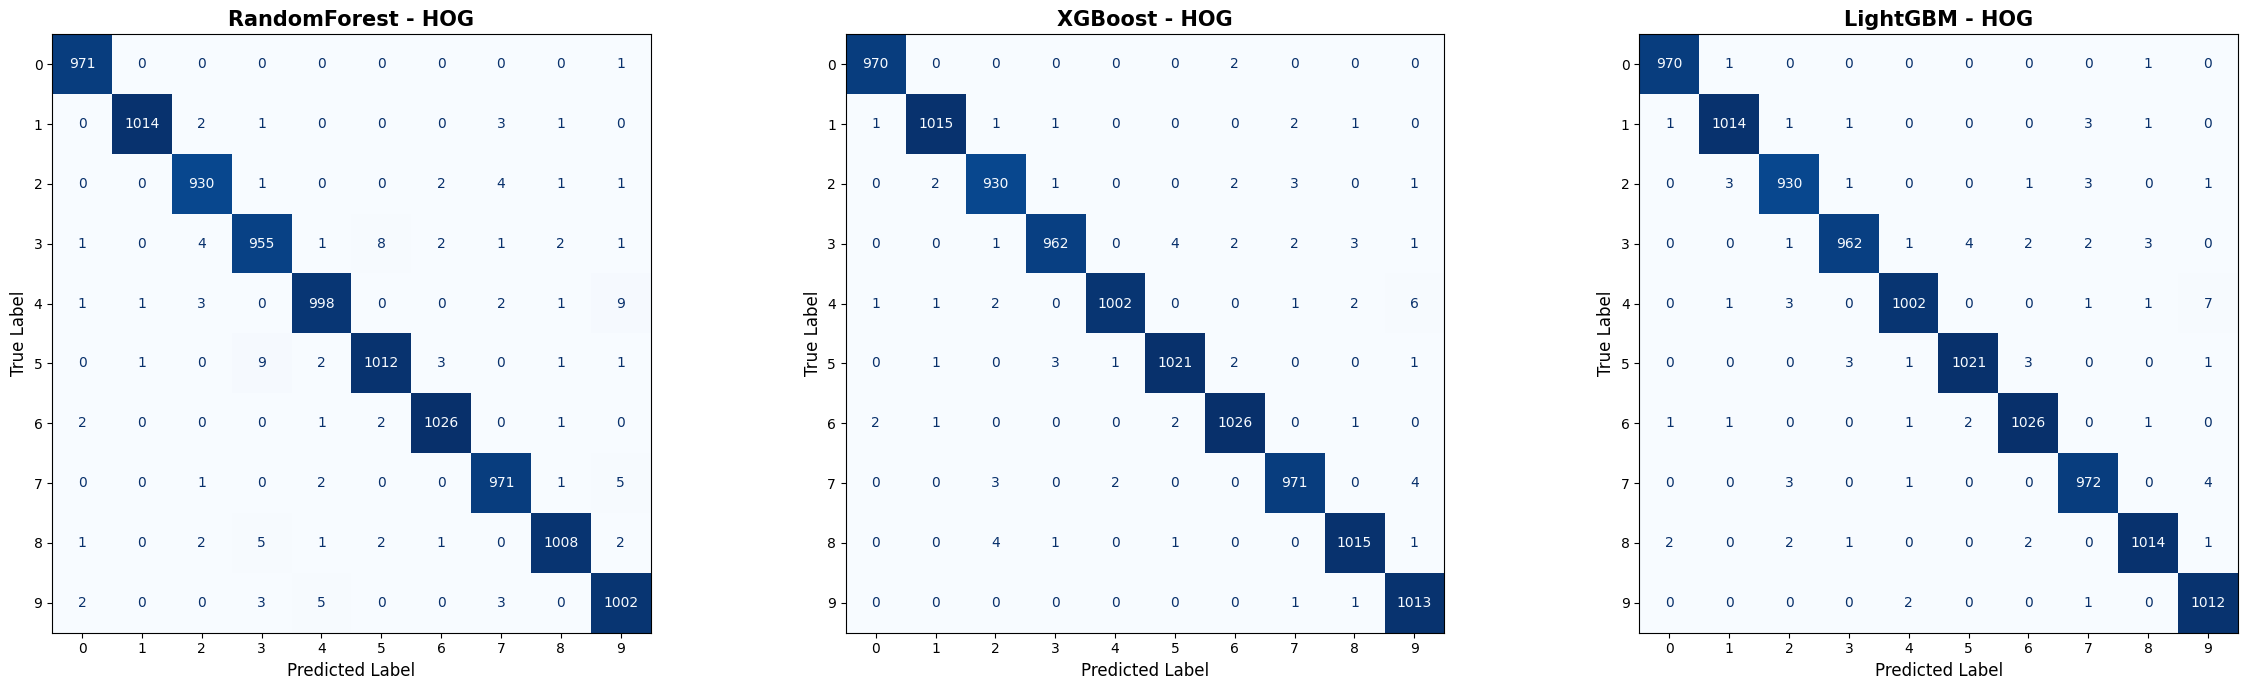

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# =========================================================
# 4. Confusion Matrix 시각화
# =========================================================
print("\n--- [Step 4] Confusion Matrix 시각화 ---")

# 그래프 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
axes = axes.flatten()

# 학습된 모델들을 순회하며 행렬 그리기
for i, (name, model) in enumerate(trained_models_hog.items()):
    
    # 1. 예측값 생성 (모델별 데이터 타입 처리)
    y_pred = None
    
    if "cuRF" in name or "RandomForest" in name:
        import cupy as cp
        # cuRF는 GPU 데이터(CuPy)를 입력으로 받음
        X_val_gpu = cp.asarray(X_val_hog)
        raw_pred = model.predict(X_val_gpu)
        
        # 결과를 CPU(NumPy)로 변환
        y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred
    else:
        # XGBoost, LightGBM은 NumPy 배열 바로 사용 가능
        y_pred = model.predict(X_val_hog)

    # 2. Confusion Matrix 계산
    # y_val_digit: 정답, y_pred: 예측값
    cm = confusion_matrix(y_val_digit, y_pred)
    
    # 3. 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    
    # 제목 및 스타일 설정
    axes[i].set_title(f"{name}", fontsize=15, fontweight='bold')
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()

## 클러스터 확인 - umap

--- [Visualization] UMAP for All 3 Models (1x3 Layout) ---
UMAP 계산 중 (Common Coordinates)...
[2025-12-01 17:02:58.640] [CUML] [info] build_algo set to brute_force_knn because random_state is given
   -> UMAP 완료 (1.14초)
[RandomForest - HOG] 예측 및 플로팅 중...
[XGBoost - HOG] 예측 및 플로팅 중...
[LightGBM - HOG] 예측 및 플로팅 중...


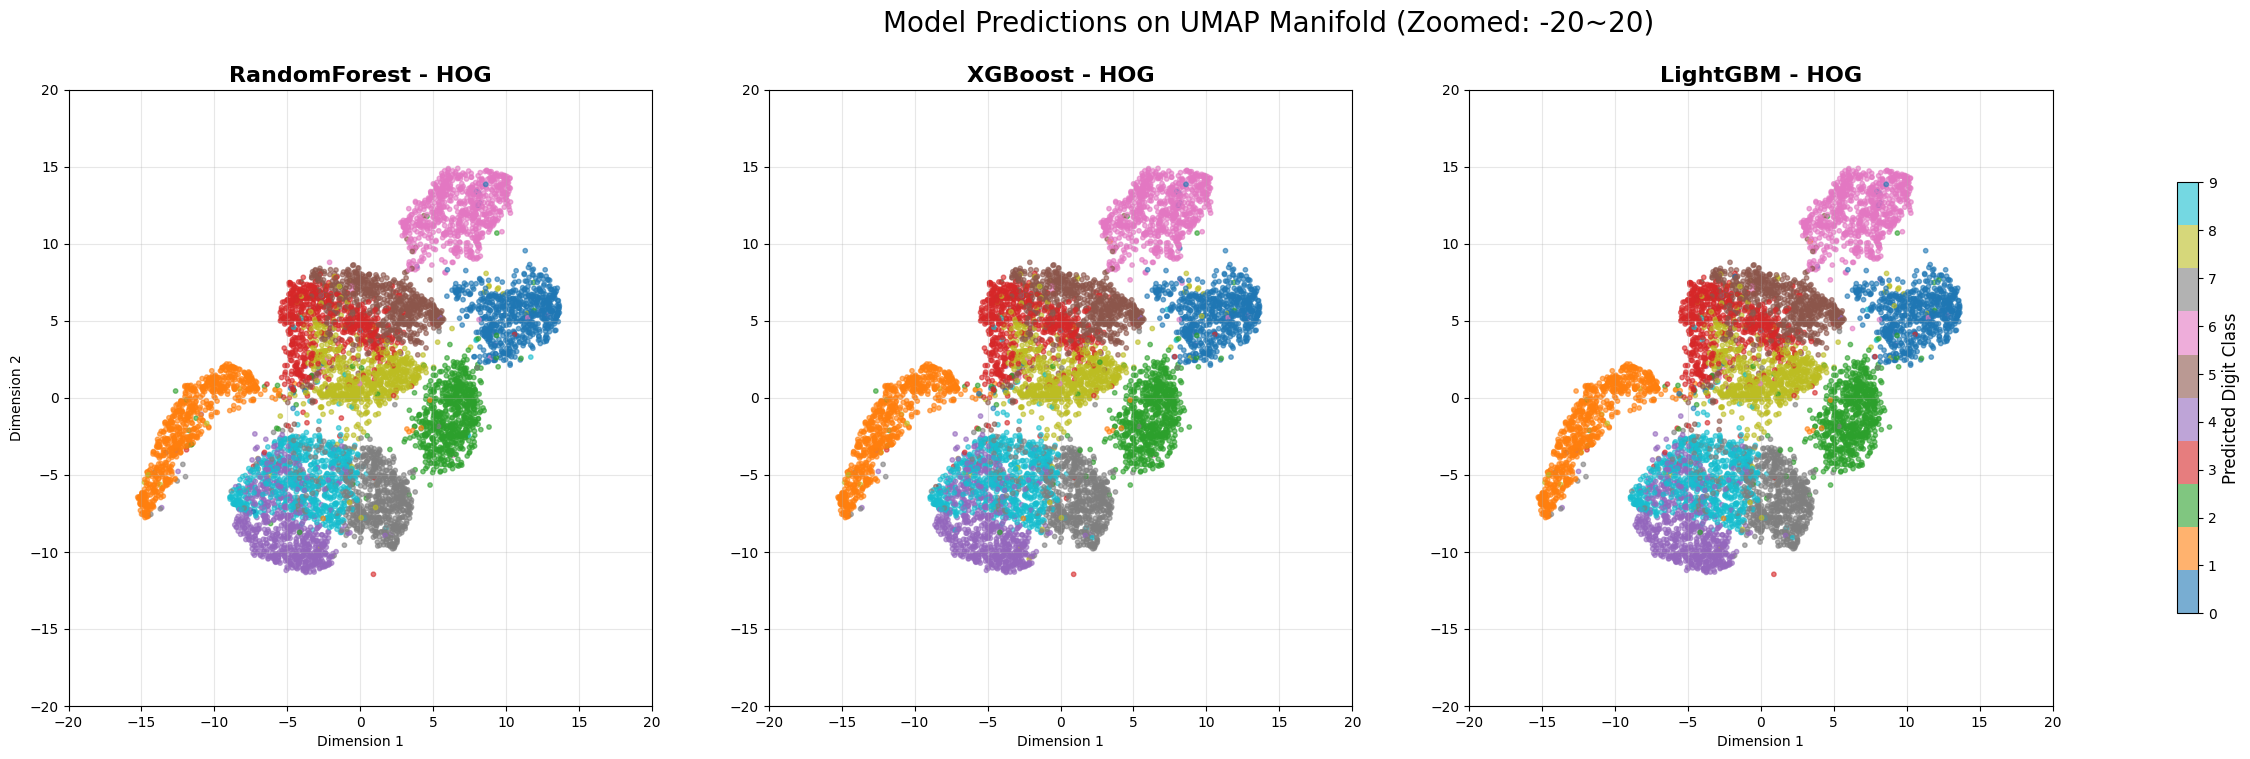

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from cuml.manifold import UMAP
import time
import cupy as cp

# =========================================================
# 3종 모델 UMAP 시각화 (1x3 배치, 좌표 고정)
# =========================================================
print("--- [Visualization] UMAP for All 3 Models (1x3 Layout) ---")

# 1. UMAP 계산 (한 번만 수행하여 좌표 고정)
# 파라미터: n_neighbors=30, min_dist=0.8, spread=2.0
print("UMAP 계산 중 (Common Coordinates)...")
start = time.time()
# random_state를 고정하여 매번 같은 모양이 나오도록 함
umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.8, metric='euclidean', spread=2.0, random_state=42)
X_umap = umap.fit_transform(X_val_hog) # X_val_hog는 Numpy 배열로 가정
print(f"   -> UMAP 완료 ({time.time()-start:.2f}초)")

# 2. 시각화 설정
fig, axes = plt.subplots(1, 3, figsize=(32, 8))
axes = axes.flatten()

# 모델 리스트 정의 (순서대로 출력)
# 딕셔너리에서 이름에 해당 키워드가 포함된 모델을 찾습니다.
target_keywords = ["RandomForest", "XGBoost", "LightGBM"]
found_models = []

for keyword in target_keywords:
    for name, model in trained_models_hog.items():
        if keyword in name:
            found_models.append((name, model))
            break

# 3. 모델별 예측 및 그리기
for i, (name, model) in enumerate(found_models):
    print(f"[{name}] 예측 및 플로팅 중...")
    
    # 예측 수행 (GPU 가속 활용)
    # 3개 모델 모두 GPU 설정이 되어 있으므로, CuPy(GPU) 데이터를 넣는 것이 효율적입니다.
    X_val_gpu = cp.asarray(X_val_hog)
    
    try:
        raw_pred = model.predict(X_val_gpu)
    except:
        # 혹시 모를 호환성 문제 시 CPU 데이터로 시도
        raw_pred = model.predict(X_val_hog)
        
    # 결과를 CPU(NumPy)로 가져오기
    y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred

    # 산점도 그리기
    # UMAP 좌표는 공유하고, 색깔(c)만 모델의 예측값으로 바꿉니다.
    ax = axes[i]
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_pred, 
                         cmap='tab10', s=10, alpha=0.6)
    
    # [핵심] 보여줄 범위 제한 (Zoom In)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    
    # 타이틀 및 레이블
    ax.set_title(f"{name}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Dimension 1")
    if i == 0: ax.set_ylabel("Dimension 2") # 첫 번째 그래프에만 Y축 레이블 표시
    ax.grid(True, alpha=0.3)

# 공통 컬러바 (오른쪽에 하나 배치)
cbar = fig.colorbar(scatter, ax=axes, location='right', shrink=0.7)
cbar.set_label('Predicted Digit Class', fontsize=12)
cbar.set_ticks(range(10))

plt.suptitle(f"Model Predictions on UMAP Manifold (Zoomed: -20~20)", fontsize=20)
plt.show()

## 클러스터 확인 - t-sne

--- [Visualization] t-SNE for All 3 Models (1x3 Layout) ---
t-SNE 계산 중 (Common Coordinates)...
   -> t-SNE 완료 (1.82초)
[RandomForest - HOG] 예측 및 플로팅 중...
[XGBoost - HOG] 예측 및 플로팅 중...
[LightGBM - HOG] 예측 및 플로팅 중...


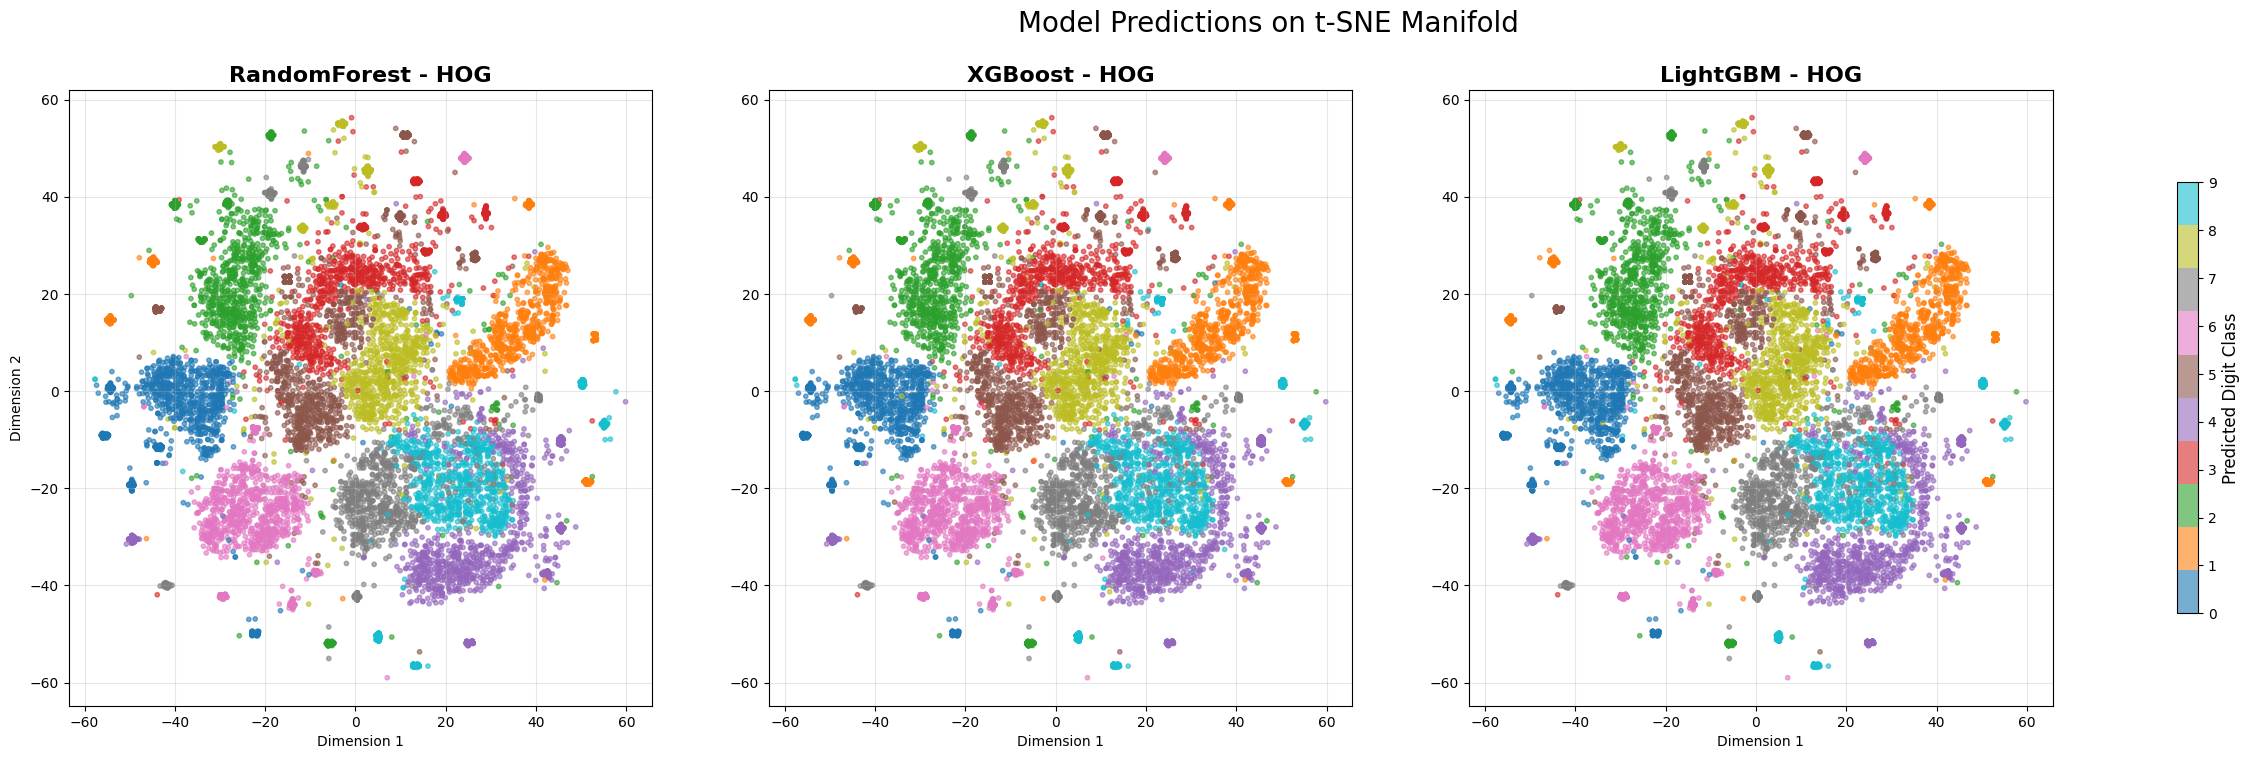

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from cuml.manifold import TSNE
import time
import cupy as cp

# =========================================================
# 3종 모델 t-SNE 시각화 (1x3 배치, 좌표 고정)
# =========================================================
print("--- [Visualization] t-SNE for All 3 Models (1x3 Layout) ---")

# 1. t-SNE 계산 (한 번만 수행하여 좌표 고정)
# 파라미터: n_components=2, perplexity=30, n_iter=1000
print("t-SNE 계산 중 (Common Coordinates)...")
start = time.time()
# random_state를 고정하여 매번 같은 모양이 나오도록 함
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_val_hog) # X_val_hog는 Numpy 배열로 가정
print(f"   -> t-SNE 완료 ({time.time()-start:.2f}초)")

# 2. 시각화 설정
fig, axes = plt.subplots(1, 3, figsize=(32, 8))
axes = axes.flatten()

# 모델 리스트 정의 (순서대로 출력)
target_keywords = ["RandomForest", "XGBoost", "LightGBM"]
found_models = []

for keyword in target_keywords:
    for name, model in trained_models_hog.items():
        if keyword in name:
            found_models.append((name, model))
            break

# 3. 모델별 예측 및 그리기
for i, (name, model) in enumerate(found_models):
    print(f"[{name}] 예측 및 플로팅 중...")
    
    # 예측 수행 (GPU 가속 활용)
    X_val_gpu = cp.asarray(X_val_hog)
    
    try:
        raw_pred = model.predict(X_val_gpu)
    except:
        raw_pred = model.predict(X_val_hog)
        
    y_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred

    # 산점도 그리기 (X_tsne 좌표 사용)
    ax = axes[i]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, 
                         cmap='tab10', s=10, alpha=0.6)
    
    # [범위 설정] t-SNE는 좌표 범위가 매번 다를 수 있어 자동 설정 권장
    # 만약 특정 부분을 확대하고 싶다면 실행 결과를 보고 아래 주석을 풀어 숫자를 조정하세요.
    # ax.set_xlim(-50, 50) 
    # ax.set_ylim(-50, 50)
    
    # 타이틀 및 레이블
    ax.set_title(f"{name}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Dimension 1")
    if i == 0: ax.set_ylabel("Dimension 2")
    ax.grid(True, alpha=0.3)

# 공통 컬러바
cbar = fig.colorbar(scatter, ax=axes, location='right', shrink=0.7)
cbar.set_label('Predicted Digit Class', fontsize=12)
cbar.set_ticks(range(10))

plt.suptitle(f"Model Predictions on t-SNE Manifold", fontsize=20)
plt.show()

## 배경제거 시각화

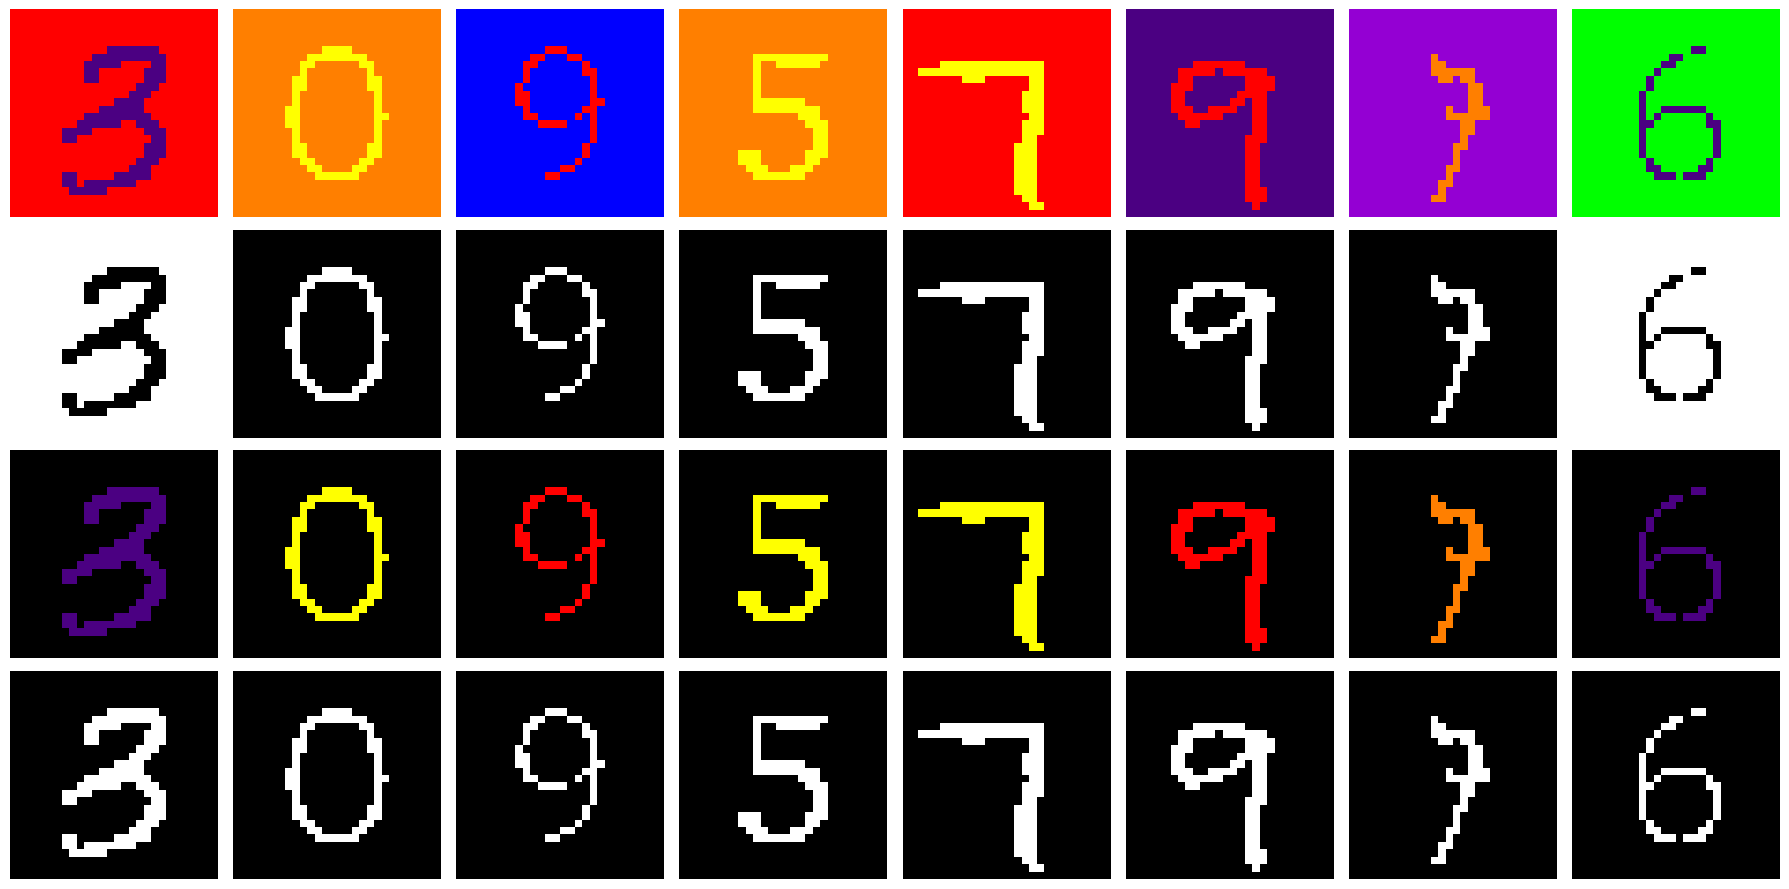

In [11]:
# (최종) Original / Gray-only / NoBG RGB / NoBG+Gray 비교 시각화 (샘플 8개)
# ===============================
num_samples = 8
idx_compare = np.random.choice(X_train_color.shape[0], num_samples, replace=False)

plt.figure(figsize=(18, 9))

for col, i in enumerate(idx_compare):

    # 1) 원본 RGB
    ax1 = plt.subplot(4, num_samples, col + 1)
    ax1.imshow(X_train_color[i])
    ax1.axis('off')
    if col == 0:
        ax1.set_ylabel("Original RGB", fontsize=12)

    # 2) Grayscale만 적용
    ax2 = plt.subplot(4, num_samples, num_samples + col + 1)
    ax2.imshow(X_train_gray[i], cmap='gray')
    ax2.axis('off')
    if col == 0:
        ax2.set_ylabel("Gray Only", fontsize=12)

    # 3) 배경제거된 RGB
    ax3 = plt.subplot(4, num_samples, 2*num_samples + col + 1)
    ax3.imshow(X_train_nobg[i])
    ax3.axis('off')
    if col == 0:
        ax3.set_ylabel("NoBG RGB", fontsize=12)

    # 4) 배경제거 + Grayscale
    ax4 = plt.subplot(4, num_samples, 3*num_samples + col + 1)
    ax4.imshow(X_train_nobg_gray[i], cmap='gray')
    ax4.axis('off')
    if col == 0:
        ax4.set_ylabel("NoBG + Gray", fontsize=12)

plt.tight_layout()
plt.show()

## 배경제거+그레이스케일+HOG

In [86]:
# =========================================================
# 7. HOG 피처 추출 (배경 제거된 Grayscale 이미지 사용)
# =========================================================
print("\n--- [Step 7] HOG 피처 추출 시작 ---")

def extract_hog_features(images):
    """
    images: (N, H, W) 형태의 Grayscale 이미지
    """
    hog_list = []
    # MNIST에 최적화된 파라미터 (4x4 셀, 2x2 블록)
    ppc = 4 
    cpb = 2 
    
    # 진행률 표시와 함께 추출
    for img in tqdm(images, desc="Extracting HOG"):
        # visualize=False로 설정하여 피처 벡터만 빠르게 추출
        feat = hog(img, pixels_per_cell=(ppc, ppc), 
                   cells_per_block=(cpb, cpb), visualize=False)
        hog_list.append(feat)
        
    return np.array(hog_list, dtype=np.float32)

# 학습 데이터 HOG 변환
print("학습 데이터 HOG 변환 중...")
X_train_hog = extract_hog_features(X_train_nobg_gray)

# 검증 데이터 HOG 변환
print("검증 데이터 HOG 변환 중...")
X_val_hog = extract_hog_features(X_val_nobg_gray)

print(f"HOG Feature Shape: {X_train_hog.shape}")
# 보통 (N, 324) 정도의 크기가 나옵니다.


# =========================================================
# 8. HOG 피처 기반 모델 학습
# =========================================================
print("\n--- [Step 8] HOG 기반 모델 3종 학습 시작 ---")

# 학습 작업 목록 정의
training_jobs_hog = [
    # 1. RandomForest (HOG)
    ("RandomForest - HOG",
     cuRF(n_estimators=100, max_depth=16, random_state=42),
     X_train_hog, y_train_digit),

    # 2. XGBoost (HOG)
    ("XGBoost - HOG",
     xgb.XGBClassifier(
         n_estimators=100, tree_method='hist', device='cuda', 
         objective='multi:softmax', num_class=10, random_state=42
     ),
     X_train_hog, y_train_digit),

    # 3. LightGBM (HOG)
    ("LightGBM - HOG",
     lgb.LGBMClassifier(
         n_estimators=100, device='cuda', objective='multiclass', 
         num_class=10, random_state=42, verbose=-1
     ),
     X_train_hog, y_train_digit),
]

trained_models_hog = {}

# 학습 루프 실행
for name, model, X_tr, y_tr in tqdm(training_jobs_hog, desc="HOG Training Progress"):
    model.fit(X_tr, y_tr)
    trained_models_hog[name] = model

print("\n--- 모든 HOG 모델 학습 완료 ---")


# =========================================================
# 9. HOG 모델 성능 평가
# =========================================================
print("\n--- [Step 9] HOG 모델 최종 성능 평가 ---")

def evaluate_model_hog(model_name, model_obj, X_val, y_val):
    print(f"\n===== {model_name} =====")

    # 1. 예측 (cuRF만 GPU -> CPU 변환 처리)
    y_pred = None
    y_proba = None
    
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)
        
        # 예측
        raw_pred = model_obj.predict(X_val_gpu)
        if hasattr(raw_pred, 'get'):
            y_pred = raw_pred.get()
        else:
            y_pred = raw_pred
            
        # 확률 (AUC용)
        try:
            raw_proba = model_obj.predict_proba(X_val_gpu)
            if hasattr(raw_proba, 'get'):
                y_proba = raw_proba.get()
            else:
                y_proba = raw_proba
        except AttributeError:
            y_proba = None
            
    else:
        # XGBoost, LightGBM
        y_pred = model_obj.predict(X_val)
        try:
            y_proba = model_obj.predict_proba(X_val)
        except AttributeError:
            y_proba = None

    # 2. 결과 출력
    if y_pred is not None:
        print(sk_classification_report(y_val, y_pred, digits=4))
    
    if y_proba is not None:
        try:
            auc = sk_roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"** Weighted-Average AUC: {auc:.4f} **")
        except Exception as e:
            print(f"AUC 계산 중 오류: {e}")

# 학습된 HOG 모델들을 순회하며 평가
for name, model in trained_models_hog.items():
    # 평가 함수에 X_val_hog 데이터를 명시적으로 전달
    evaluate_model_hog(name, model, X_val_hog, y_val_digit)


--- [Step 7] HOG 피처 추출 시작 ---
학습 데이터 HOG 변환 중...


Extracting HOG:   0%|          | 0/60000 [00:00<?, ?it/s]

검증 데이터 HOG 변환 중...


Extracting HOG:   0%|          | 0/10000 [00:00<?, ?it/s]

HOG Feature Shape: (60000, 1296)

--- [Step 8] HOG 기반 모델 3종 학습 시작 ---


HOG Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


--- 모든 HOG 모델 학습 완료 ---

--- [Step 9] HOG 모델 최종 성능 평가 ---

===== RandomForest - HOG =====
              precision    recall  f1-score   support

         0.0     0.9928    0.9990    0.9959       972
         1.0     0.9980    0.9931    0.9956      1021
         2.0     0.9873    0.9904    0.9888       939
         3.0     0.9805    0.9795    0.9800       975
         4.0     0.9881    0.9833    0.9857      1015
         5.0     0.9883    0.9835    0.9859      1029
         6.0     0.9923    0.9942    0.9932      1032
         7.0     0.9868    0.9908    0.9888       980
         8.0     0.9921    0.9863    0.9892      1022
         9.0     0.9804    0.9872    0.9838      1015

    accuracy                         0.9887     10000
   macro avg     0.9887    0.9887    0.9887     10000
weighted avg     0.9887    0.9887    0.9887     10000

** Weighted-Average AUC: 0.9999 **

===== XGBoost - HOG =====
              precision    recall  f1-score   support

         0.0     0.9959    0.9979

## 과적합 판단

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score

# ==========================================
# 과적합(Overfitting) 진단 함수
# ==========================================
def check_overfitting_hog(model_name, model_obj, X_train, y_train, X_val, y_val):
    print(f"\n===== [과적합 체크] {model_name} =====")
    
    # 1. 학습 데이터(Train)에 대한 예측
    # (모델이 공부한 내용을 얼마나 잘 외웠는지 확인)
    y_train_pred = None
    if "cuRF" in model_name:
        import cupy as cp
        # cuRF는 입력이 numpy면 자동으로 변환해주기도 하지만, 안전하게 처리
        X_tr_gpu = cp.asarray(X_train)
        raw_pred = model_obj.predict(X_tr_gpu)
        y_train_pred = raw_pred.get() if hasattr(raw_pred, 'get') else raw_pred
    else:
        # XGBoost, LightGBM
        y_train_pred = model_obj.predict(X_train)
        
    # 2. 검증 데이터(Validation)에 대한 예측
    # (처음 보는 문제에 대한 응용력 확인)
    y_val_pred = None
    if "cuRF" in model_name:
        import cupy as cp
        X_val_gpu = cp.asarray(X_val)
        raw_pred_val = model_obj.predict(X_val_gpu)
        y_val_pred = raw_pred_val.get() if hasattr(raw_pred_val, 'get') else raw_pred_val
    else:
        y_val_pred = model_obj.predict(X_val)
        
    # 3. 정확도 계산 및 비교
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    # Gap 계산 (Train - Val)
    gap = train_acc - val_acc
    
    # 4. 결과 출력
    print(f"   - 학습 정확도 (Train) : {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   - 검증 정확도 (Val)   : {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   - 차이 (Gap)          : {gap:.4f} ({gap*100:.2f}% 차이)")
    
    # 5. 진단 메시지
    if gap > 0.10:
        print("   🔥 [위험] 심각한 과적합(Overfitting)입니다! 모델이 학습 데이터를 암기하고 있습니다.")
    elif gap > 0.05:
        print("   🚨 [경고] 과적합 조짐이 있습니다. (차이 > 5%)")
    elif val_acc < 0.60:
        print("   ⚠️ [주의] 과소적합(Underfitting) 가능성이 있습니다. 학습이 더 필요합니다.")
    else:
        print("   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)")

# ==========================================
# 실행 코드
# ==========================================
print("--- HOG 모델 과적합 진단 시작 ---")

# trained_models_hog 딕셔너리에 있는 모든 모델 검사
# 데이터는 X_train_hog, X_val_hog 사용
for name, model in trained_models_hog.items():
    check_overfitting_hog(name, model, 
                          X_train_hog, y_train_digit, 
                          X_val_hog, y_val_digit)

--- HOG 모델 과적합 진단 시작 ---

===== [과적합 체크] RandomForest (HOG+Bin) =====
   - 학습 정확도 (Train) : 0.9998 (99.98%)
   - 검증 정확도 (Val)   : 0.9891 (98.91%)
   - 차이 (Gap)          : 0.0107 (1.07% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)

===== [과적합 체크] XGBoost (HOG+Bin) =====
   - 학습 정확도 (Train) : 1.0000 (100.00%)
   - 검증 정확도 (Val)   : 0.9929 (99.29%)
   - 차이 (Gap)          : 0.0071 (0.71% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)

===== [과적합 체크] LightGBM (HOG+Bin) =====
   - 학습 정확도 (Train) : 1.0000 (100.00%)
   - 검증 정확도 (Val)   : 0.9931 (99.31%)
   - 차이 (Gap)          : 0.0069 (0.69% 차이)
   ✅ [양호] 학습이 안정적으로 잘 되었습니다. (Good Fit)


## 색상 처리 시간 단축 코드 수정 필요


In [ ]:
def extract_smart_color_features(images_color_flat, images_gray_flat, threshold=0.1):
    N = images_color_flat.shape[0]
    # shape 복구
    images_color = images_color_flat.reshape(N, 28, 28, 3)
    images_gray = images_gray_flat.reshape(N, 28, 28)

    fg_features = np.zeros((N, 3))
    bg_features = np.zeros((N, 3))

    # BG: 네 모서리 평균
    corners = images_color[:, [0, 0, -1, -1], [0, -1, 0, -1], :]
    bg_features = np.mean(corners, axis=1)

    # FG: 마스킹
    for i in range(N):
        mask = images_gray[i] > threshold
        if np.sum(mask) > 0:
            fg_features[i] = np.mean(images_color[i][mask], axis=0)
        else:
            # 여전히 숫자가 안 보이면 배경색으로 대체
            fg_features[i] = bg_features[i]

    return fg_features, bg_features

# --- [Step 2] 데이터 변환 (Correct Threshold) ---
print(">>> [수정됨] 색상 데이터 다시 추출 중 (Threshold=0.1)...")
# 학습 데이터
X_train_fg, X_train_bg = extract_smart_color_features(X_train_flat_color, X_train_flat_gray, threshold=0.1)
# 테스트 데이터
X_val_fg, X_val_bg = extract_smart_color_features(X_val_flat_color, X_val_flat_gray, threshold=0.1)
print(">>> 변환 완료 (FG)")

# --- [Step 3] 모델 학습 & 평가 (RF, XGB, LGBM Only) ---
training_jobs = [
    # 1. Foreground (전경색)
    ("RF - FG", cuRF(n_estimators=100, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("XGB - FG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("LGBM - FG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_fg, y_train_fg, X_val_fg, y_val_fg),

    # 2. Background (배경색)
    ("RF - BG", cuRF(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("XGB - BG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("LGBM - BG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
]

# 시각화 설정
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("\n>>> 모델 학습 시작")
results = {}

for i, (name, model, X_tr, y_tr, X_te, y_te) in enumerate(tqdm(training_jobs)):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = sk_accuracy_score(y_te, y_pred)
    results[name] = acc

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2%}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== 🏆 Final Score (Redemption Round) ===")
for name, acc in results.items():
    print(f"{name:<15} : {acc:.2%}")